# Set up

In [ ]:
pip install statsmodels

In [ ]:
!pip install country_converter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 1.3 MB/s eta 0:00:00


In [ ]:
pip install tabulate

In [ ]:
#Các thư viện
#Dataframe
import pandas as pd
import numpy as np
import scipy as sp
from tabulate import tabulate

#Biểu đồ
import matplotlib.cm        as cm
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import country_converter as coco

# Tiền xử lý
from statsmodels.formula.api      import ols
from statsmodels.stats.multicomp  import pairwise_tukeyhsd
from scipy.stats                  import norm, chi2_contingency, gaussian_kde, shapiro
from sklearn.preprocessing        import LabelEncoder, MinMaxScaler
from sklearn.decomposition        import PCA


# Mô hình
from sklearn.model_selection      import train_test_split, GridSearchCV, cross_val_predict, learning_curve
from sklearn.ensemble             import RandomForestRegressor
from sklearn.linear_model         import LinearRegression
from sklearn.svm                  import SVR
from sklearn.cluster              import KMeans, AgglomerativeClustering
from scipy.cluster                import hierarchy
from yellowbrick.cluster          import KElbowVisualizer

# Đánh giá
from sklearn.metrics              import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error, explained_variance_score, max_error, make_scorer, silhouette_samples, silhouette_score
from scipy.spatial.distance       import cdist
from sklearn.model_selection import cross_val_score

# Lơ đi cảnh báo
import warnings
warnings.filterwarnings('ignore')


#styling
%matplotlib inline

# Tổng quan bộ dữ liệu

In [ ]:
df = pd.read_csv('/content/salaries.csv')
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,EX,FT,Data Science Director,212000,USD,212000,US,0,US,M
1,2023,EX,FT,Data Science Director,190000,USD,190000,US,0,US,M
2,2023,MI,FT,Business Intelligence Engineer,35000,GBP,43064,GB,0,GB,M
3,2023,MI,FT,Business Intelligence Engineer,35000,GBP,43064,GB,0,GB,M
4,2023,SE,FT,Machine Learning Engineer,245700,USD,245700,US,0,US,M


In [ ]:
df.info()
print("số lượng phần tử bộ dữ liệu:", df.size)
print("Số dòng và cột bộ dữ liệu:", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8805 entries, 0 to 8804
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           8805 non-null   int64 
 1   experience_level    8805 non-null   object
 2   employment_type     8805 non-null   object
 3   job_title           8805 non-null   object
 4   salary              8805 non-null   int64 
 5   salary_currency     8805 non-null   object
 6   salary_in_usd       8805 non-null   int64 
 7   employee_residence  8805 non-null   object
 8   remote_ratio        8805 non-null   int64 
 9   company_location    8805 non-null   object
 10  company_size        8805 non-null   object
dtypes: int64(4), object(7)
memory usage: 756.8+ KB
số lượng phần tử bộ dữ liệu: 96855
Số dòng và cột bộ dữ liệu: (8805, 11)


In [ ]:
# Kiểm tra Null value
df.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [ ]:
numerical = df[['work_year', 'salary','salary_in_usd', 'remote_ratio']]
scaler = MinMaxScaler()
scaler.fit(numerical)
numerical = scaler.transform(numerical)
numerical = pd.DataFrame(numerical, columns = [['work_year', 'salary','salary_in_usd', 'remote_ratio']])
numerical.head()

,work_year,salary,salary_in_usd,remote_ratio
0,1.0,0.006516,0.328223,0.0
1,1.0,0.005792,0.291569,0.0
2,1.0,0.000691,0.046758,0.0
3,1.0,0.000691,0.046758,0.0
4,1.0,0.007625,0.384371,0.0


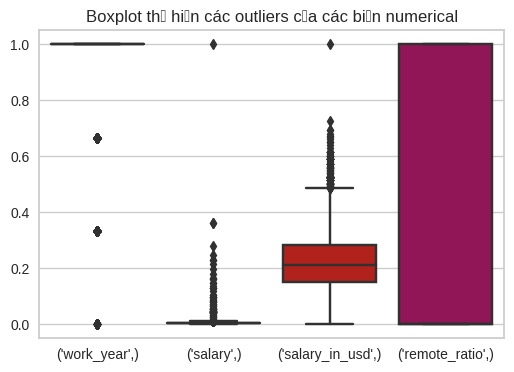

In [ ]:
numeric_columns = ['work_year', 'salary', 'salary_in_usd', 'remote_ratio']
plt.subplots(figsize = (6,4))
sns.boxplot(numerical)
plt.title("Boxplot thể hiện các outliers của các biến numerical")
plt.show()

## Phân tích khám phá dữ liệu

In [ ]:
df.drop(df[['salary','salary_currency']],axis=1, inplace=True)

* Bỏ 2 thuộc tính salary và salary_currency vì đã có thuộc tính salary_in_USD chuyển tiền lương về chung một đơn vị tiền là USD.

### Nhận diện các biến


In [ ]:
# Đổi những biến work_year và biến remote_ratio thành biến phân loại
df["work_year"] = df["work_year"].astype(object)
df['remote_ratio_clean']=df['remote_ratio']
df["remote_ratio"].replace([100,50,0], ['No remote work', 'Partially remote' ,'Fully remote'],inplace = True)

# Đổi giá trị của những biến còn lại
df['salary_in_usd'] = df['salary_in_usd'].astype(int)
df["experience_level"].replace(['EN','MI','SE', 'EX'], ['Entry', 'Mid', 'Senior', 'Executive'], inplace = True)
df["employment_type"].replace(["PT", "FT", "CT", "FL"], ["Part-time", "Full-time", "Contract", "Freelance"], inplace=True)
df["company_size"].replace(["S", "M", "L"], ["Small", "Medium", "Large"], inplace=True)

# Chuyển đổi ký hiệu quốc gia thường trú của công ty thành theo mã quốc gia ISO3
converted_country_ = coco.convert(names=df['company_location'], to="ISO3")
df['company_location'] = converted_country_
# Chuyển đổi ký hiệu quốc gia thường trú của nhân viên thành theo mã quốc gia ISO3
converted_country = coco.convert(names=df['employee_residence'], to="ISO3")
df['employee_residence'] = converted_country

# Chương 3. Tiền xử lý dữ liệu

## l.Phân tích đơn biến - thống kê mô tả

In [ ]:
# Xem bảng mô tả của các cột phân loại
df.describe(include = 'O')

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
count,8805,8805,8805,8805,8805,8805,8805,8805
unique,4,4,4,124,86,3,74,3
top,2023,Senior,Full-time,Data Engineer,USA,Fully remote,USA,Medium
freq,6861,6336,8762,2062,7527,5289,7576,7881


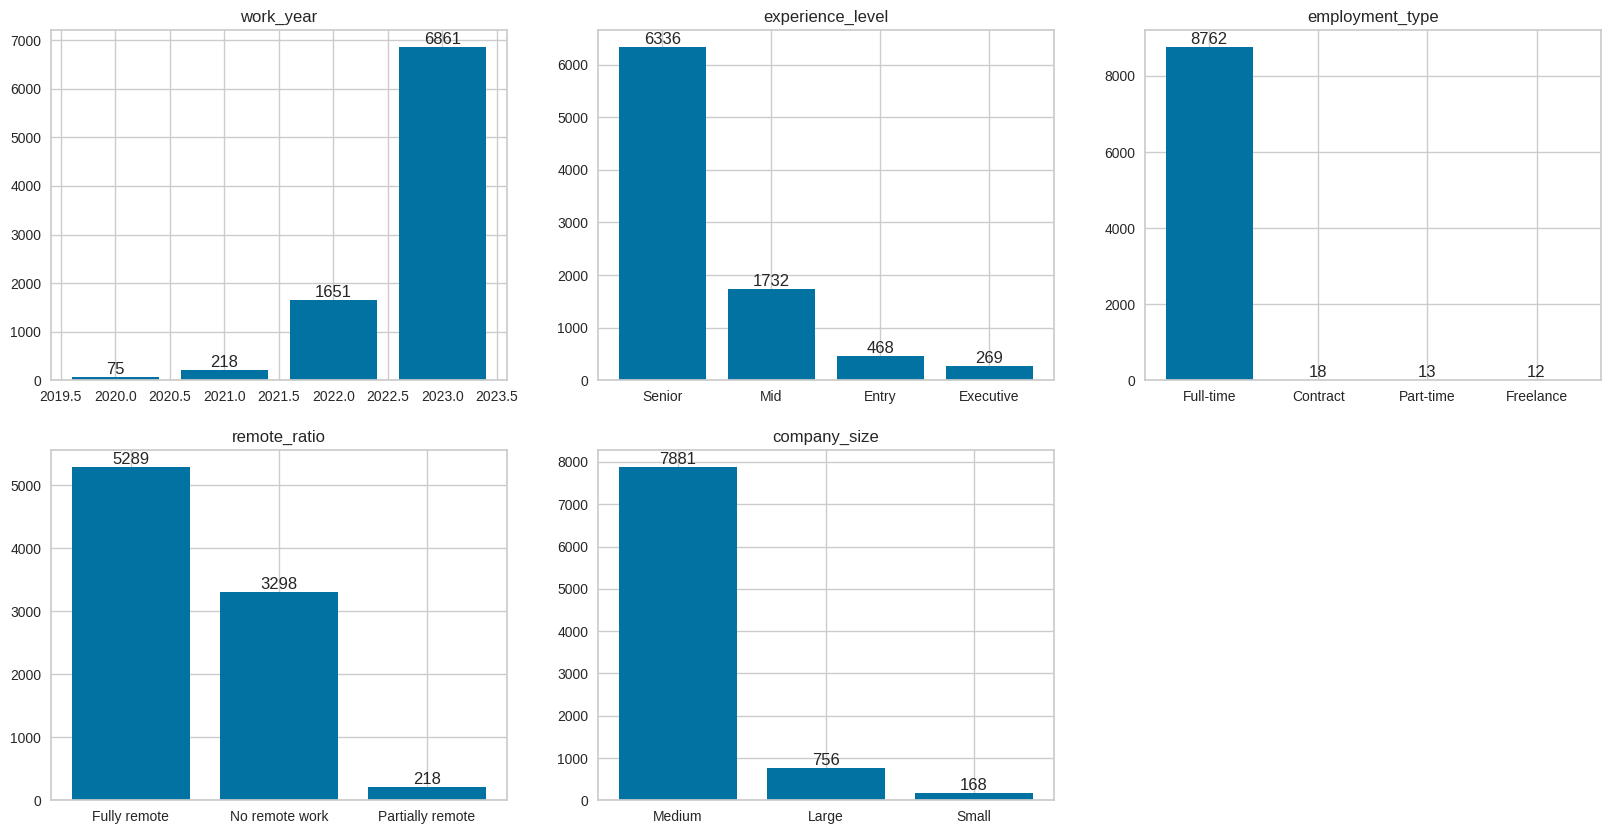

In [ ]:
# Phân tích những cột phân loại có ít danh mục:
cat_col = df.select_dtypes(include='object').columns
cat_col_less = [col for col in cat_col if df[col].nunique() <= 5]


plt.figure(figsize=([20, 10]))  # Khung (width, height): inch
for i in range(len(cat_col_less)):
    counts = df[cat_col_less[i]].value_counts()
    plt.subplot(2, 3, (i + 1))  # Subplot 1 trong ma trận (2 rows, 3 cols)
    plt.title(cat_col_less[i])
    bars = plt.bar(counts.index, counts.values)


    # Thêm thông số số lượng dữ liệu trên mỗi cột
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, round(yval, 2), ha='center', va='bottom')


plt.show()


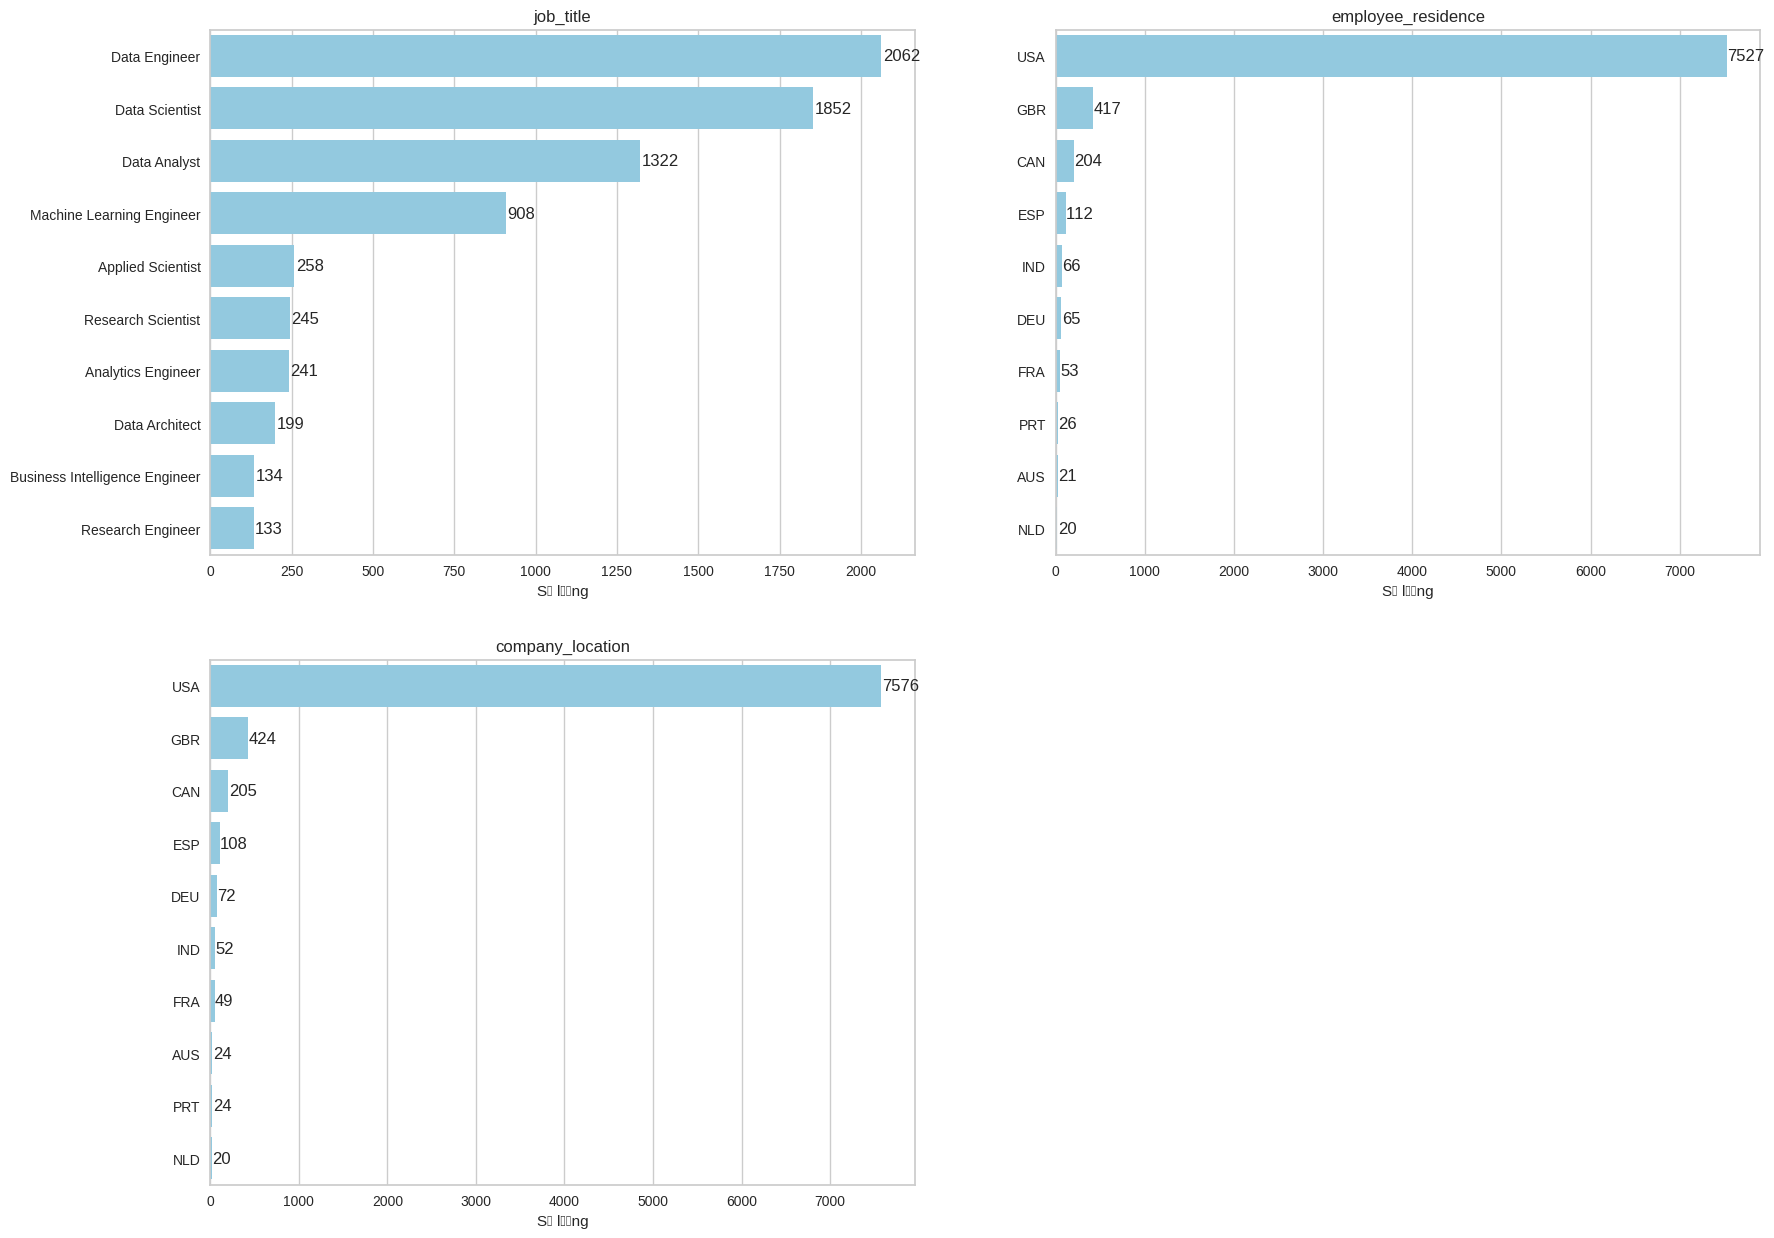

In [ ]:
# Biểu đồ thanh biểu diễn top 10 các thuộc tính có nhiều danh mục
cat_col_much = [col for col in cat_col if df[col].nunique() > 5]

plt.figure(figsize=(20, 15))
for i in range(len(cat_col_much)):
  plt.subplot(2, 2, (i+1)) # subplot 1 trong ma trận (2 rows, 3 cols)
  top10 = df[cat_col_much[i]].value_counts()[:10]
  ax = sns.barplot(x=top10.values, y=top10.index,color='skyblue')
  ax.set_xlabel('Số lượng')
  ax.set_title(cat_col_much[i])
  for j, v in enumerate(top10.values):
    ax.annotate(str(v), xy=(v+5,j), va='center')
plt.show()

In [ ]:
print('Số lượng danh xưng công việc trong bộ dữ liệu là:', df['job_title'].value_counts().size)

Số lượng danh xưng công việc trong bộ dữ liệu là: 124


In [ ]:
# Vì chúng ta có nhiều giá trị trong cột chức danh công việc
# Hãy tạo một hàm để xác định các vai trò được lặp lại nhiều nhất dựa trên từ khóa

def role(title):
    if any(keyword in title.lower() for keyword in ['data scientist', 'data science', 'scientist']):
        return 'Data Scientist'
    elif any(keyword in title.lower() for keyword in ['data analyst', 'analyst']):
        return 'Data Analyst'
    elif any(keyword in title.lower() for keyword in ['data engineer']):
        return 'Data Engineer'
    elif any(keyword in title.lower() for keyword in ['machine learning engineer', 'machine learning', 'ai', 'ml', 'deep learning']):
        return 'Machine Learning Engineer'
    else:
        return 'Other'

In [ ]:
# Tạo cột mới cho các chức danh công việc
df['job_title_clean'] = df['job_title'].apply(role)
df['job_title_clean'].value_counts()

Data Scientist               2752
Data Engineer                2093
Data Analyst                 1528
Other                        1247
Machine Learning Engineer    1185
Name: job_title_clean, dtype: int64

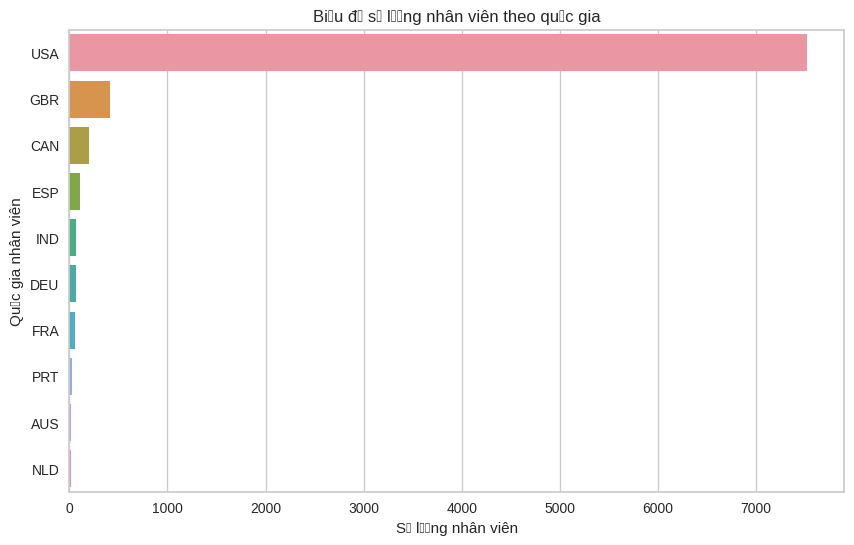

In [ ]:
employee_res = df['employee_residence'].value_counts()
top_10_employees = employee_res.head(10)


plt.figure(figsize=(10, 6))
sns.countplot(y='employee_residence',
data=df, order=top_10_employees.index)
plt.xlabel('Số lượng nhân viên')
plt.ylabel('Quốc gia nhân viên')
plt.title('Biểu đồ số lượng nhân viên theo quốc gia')
plt.show()


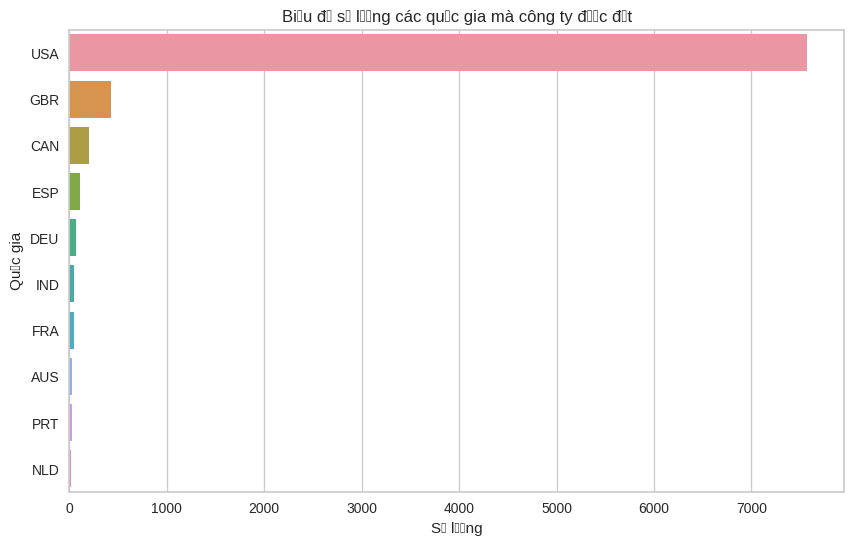

In [ ]:
company_loc = df['company_location'].value_counts()
top_10_company = company_loc.head(10)


plt.figure(figsize=(10, 6))
sns.countplot(y='company_location', data=df, order=top_10_company.index)
plt.xlabel('Số lượng')
plt.ylabel('Quốc gia')
plt.title('Biểu đồ số lượng các quốc gia mà công ty được đặt')
plt.show()


### Vẽ biểu đồ phân phối với KDE và biểu đồ box plot


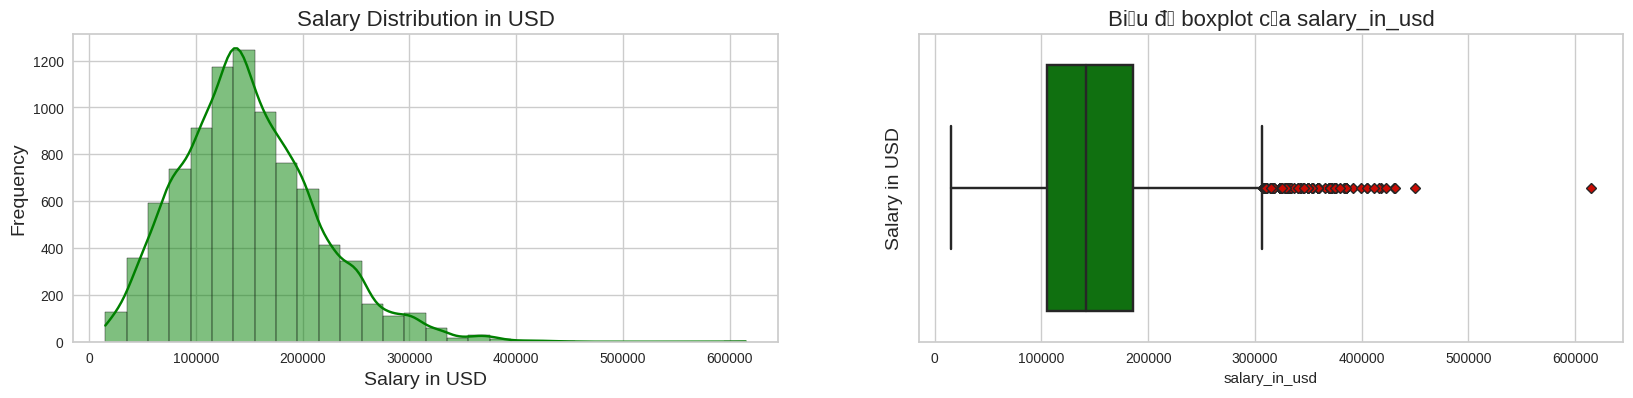

In [ ]:
# Tạo biểu đồ phân phối với KDE và box plot
fig, ax = plt.subplots(1, 2, figsize=(20, 4))

sns.histplot(df['salary_in_usd'], bins=30, kde=True, color='green', edgecolor='k', ax=ax[0])

ax[0].set_title('Salary Distribution in USD', fontsize=16)
ax[0].set_xlabel('Salary in USD', fontsize=14)
ax[0].set_ylabel('Frequency', fontsize=14)

outlier = dict(marker = 'D', markerfacecolor = 'r')
sns.boxplot(x=df['salary_in_usd'], color='green',flierprops = outlier, ax=ax[1])

ax[1].set_title('Biểu đồ boxplot của salary_in_usd', fontsize=16)
ax[1].set_ylabel('Salary in USD', fontsize=14)

plt.show()


### Các đại lượng về xu thế trung tâm

In [ ]:
print('Các đại lượng về xu thế trung tâm:')
print("  - Trung bình (Mean):",round(np.mean(df['salary_in_usd']),4))
print('  - Trung vị (Median):',round(np.median(df['salary_in_usd']),4))
print('  - Yếu vị (Mode):',sp.stats.mode(df['salary_in_usd'])[0],'với số lần là',sp.stats.mode(df['salary_in_usd'])[1])


Các đại lượng về xu thế trung tâm:
  - Trung bình (Mean): 149488.2656
  - Trung vị (Median): 142200.0
  - Yếu vị (Mode): 150000 với số lần là 188


### Các đại lượng về độ phân tán

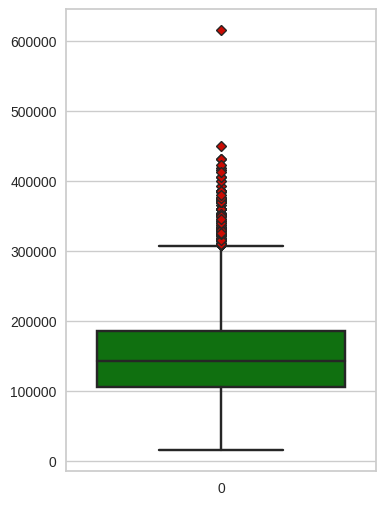


Các đại lượng về độ phân tán:
  - Khoảng biến thiên (Range): 600201
  - Tứ phân vị (Quartile):
     Q1: 105000.0
     Q2: 142200.0
     Q3: 185900.0
  - Khoảng trải giữa (InterQuartile Range): 80900.0
  - Phương sai (Variance): 4124010353.5111
  - Độ lệch chuẩn (Standard Deviation): 64218.458


In [ ]:
plt.figure(figsize = (4, 6))
outlier = dict(marker = 'D', markerfacecolor = 'r')
sns.boxplot(df['salary_in_usd'], flierprops = outlier, color ='green')
plt.show()

## Các đại lượng về độ phân tán
print('\nCác đại lượng về độ phân tán:')

# Khoảng biến thiên (Range)
data_range = np.max(df['salary_in_usd']) - np.min(df['salary_in_usd'])
print("  - Khoảng biến thiên (Range):", data_range)

# Tứ phân vị (Quartile)
q1 = np.percentile(df['salary_in_usd'], 25)
q2 = np.percentile(df['salary_in_usd'], 50)
q3 = np.percentile(df['salary_in_usd'], 75)
print("  - Tứ phân vị (Quartile):")
print("     Q1:", q1)
print("     Q2:", q2)
print("     Q3:", q3)

# Khoảng trải giữa (InterQuartile Range)
iqr = q3 - q1
print("  - Khoảng trải giữa (InterQuartile Range):", iqr)

# Phương sai (Variance)
variance = np.var(df['salary_in_usd'])
print("  - Phương sai (Variance):", round(variance,4))

# Độ lệch chuẩn (Standard deviation)
std_deviation = np.std(df['salary_in_usd'])
print("  - Độ lệch chuẩn (Standard Deviation):", round(std_deviation,4))

### Các đại lượng về hình dáng

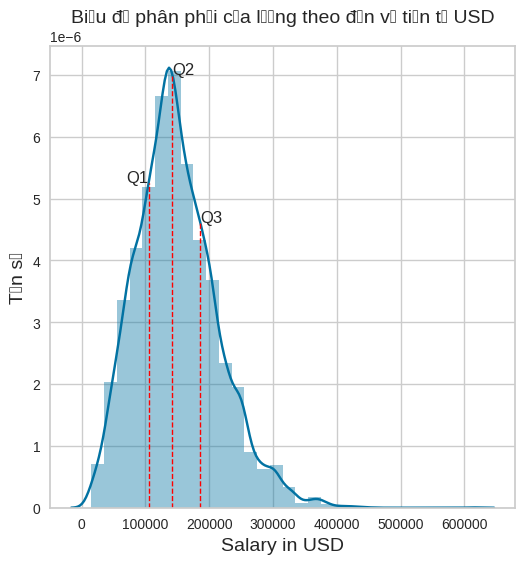


Các đại lượng về hình dáng:
  - Độ nghiêng (skewness): 0.6462
  - Độ nhọn (kurtosis): 0.86


In [ ]:
#Các đại lượng về hình dáng
# Vẽ biểu đồ phân phối
plt.figure(figsize = (6, 6))
sns.distplot(df['salary_in_usd'], bins=30, kde=True, hist = True)
plt.title('Biểu đồ phân phối của lương theo đơn vị tiền tệ USD', fontsize=14)
plt.xlabel('Salary in USD', fontsize=14)
plt.ylabel('Tần số', fontsize=14)
percentiles = np.percentile(df['salary_in_usd'], [25, 50, 75])
 # Calculate heights of quartiles as the height of kde at the quartile positions
kde = gaussian_kde(df['salary_in_usd'])
kde_q75 = kde(q3)
kde_q50 = kde(q2)
kde_q25 = kde(q1)
# Add labels for quartiles
plt.text(q3, kde_q75, 'Q3', horizontalalignment='left')
plt.text(q2, kde_q50, 'Q2', horizontalalignment='left')
plt.text(q1, kde_q25, 'Q1', horizontalalignment='right')

for percentile in [q1, q2, q3]:
    plt.axvline(percentile, color='red', linestyle='--', linewidth=1, ymax = kde(percentile)/(7.5*1e-6) )
plt.show()
print('\nCác đại lượng về hình dáng:')
salaries = df['salary_in_usd']
#a. Độ nghiêng (skewness)
skewness = sp.stats.skew(salaries)
print("  - Độ nghiêng (skewness):", round(skewness,4))
#b. Độ nhọn (kurtosis)
kurtosis = sp.stats.kurtosis(salaries)
print("  - Độ nhọn (kurtosis):", round(kurtosis,4))


## II. Làm sạch dữ liệu

### Dữ liệu bị thiếu

In [ ]:
## Đếm số dòng chứa NA (None, NaN) của mỗi cột
print('*** Số lượng giá trị bị thiếu của các cột:')
print(len(df) - df.count())

*** Số lượng giá trị bị thiếu của các cột:
work_year             0
experience_level      0
employment_type       0
job_title             0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
remote_ratio_clean    0
job_title_clean       0
dtype: int64


* Bộ dữ liệu không có dòng nào bị thiếu nên bỏ qua bước xử lý dữ liệu bị thiếu.

### Dữ liệu bị nhiễu

In [ ]:
# Xử lý dữ liệu bị nhiễu
Q1 = df['salary_in_usd'].quantile(0.25)
Q3 = df['salary_in_usd'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier = df[(df['salary_in_usd'] < lower_bound) | (df['salary_in_usd'] > upper_bound)]
df = df[(df['salary_in_usd'] >= lower_bound) & (df['salary_in_usd'] <= upper_bound)]

print(f"Số giá trị bị loại bỏ: {len(outlier)}")

Số giá trị bị loại bỏ: 159


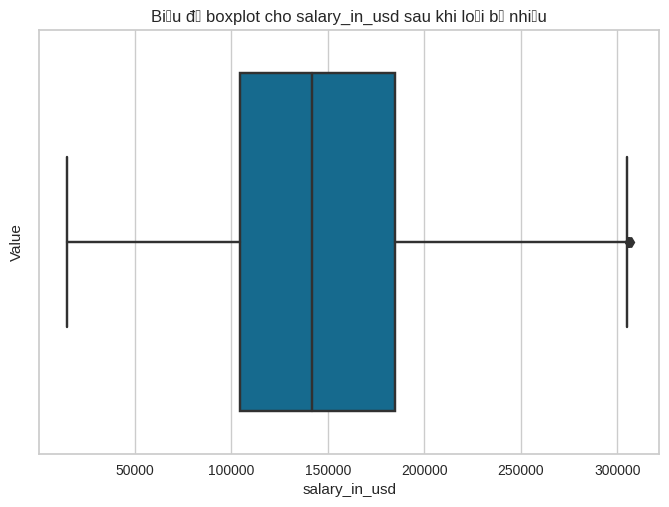

In [ ]:
plt.title('Biểu đồ boxplot cho salary_in_usd sau khi loại bỏ nhiễu')
plt.xlabel('salary_in_usd')
sns.boxplot(x='salary_in_usd', data=df)
plt.ylabel('Value')
plt.show()

### Kiểm định tương quan

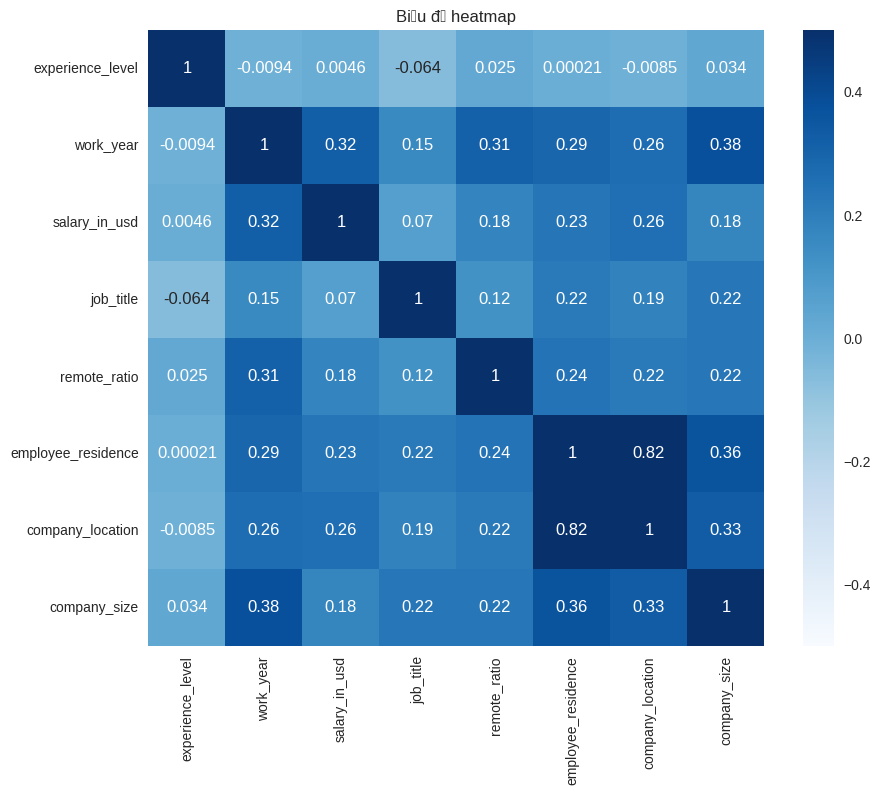

In [ ]:
vars = ['experience_level', 'work_year', 'salary_in_usd', 'job_title', 'remote_ratio', 'employee_residence', 'company_location', 'company_size']

# Tạo ma trận tương quan giữa các biến
corr_matrix = df[vars].apply(lambda x: pd.factorize(x)[0]).corr()

# Tạo heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', square=True, vmin=-0.5, vmax=0.5)

# Hiển thị biểu đồ
plt.title('Biểu đồ heatmap')
plt.show()


#### Kiểm định Chi-squared

In [ ]:
# Bước 1: Tạo bảng chéo crosstab giữa biến employee_residence và company_location
crosstab_table = pd.crosstab(df['employee_residence'], df['company_location'])

# Bước 2: Chuyển đổi bảng crosstab thành array
observed_array = crosstab_table.values

# Bước 3: Kiểm định Chi-square và kết luận theo phương pháp p-value
chi2, p, _, _ = chi2_contingency(observed_array)

alpha = 0.05
confidence_level = 1 - alpha

if p < alpha:
    conclusion = "Bác bỏ giả thuyết Ho: employee_residence và company_location là PHỤ THUỘC lẫn nhau."
else:
    conclusion = "Không thể bác bỏ giả thuyết Ho: employee_residence và company_location là ĐỘC LẬP."

# In kết quả
print("Kết quả kiểm định Chi-square:")
print("p-value: {:.10f}".format(p))
print("Kết luận:", conclusion)


Kết quả kiểm định Chi-square:
p-value: 0.0000000000
Kết luận: Bác bỏ giả thuyết Ho: employee_residence và company_location là PHỤ THUỘC lẫn nhau.


#### Kiểm định ANOVA

In [ ]:
# 1. Tạo dataframe chứa các mẫu dữ liệu
_2020=df[df['work_year']==2020]['salary_in_usd'].reset_index(drop=True)
_2021=df[df['work_year']==2021]['salary_in_usd'].reset_index(drop=True)
_2022=df[df['work_year']==2022]['salary_in_usd'].reset_index(drop=True)
_2023=df[df['work_year']==2023]['salary_in_usd'].reset_index(drop=True)
data=pd.DataFrame({'_2020':_2020,'_2021':_2021,'_2022':_2022,'_2023':_2023})
data.head()


,_2020,_2021,_2022,_2023
0,100000.0,185000.0,36940.0,212000
1,44753.0,56000.0,80000.0,190000
2,164000.0,60000.0,97712.0,43064
3,47899.0,150000.0,16455.0,43064
4,300000.0,30000.0,15000.0,245700


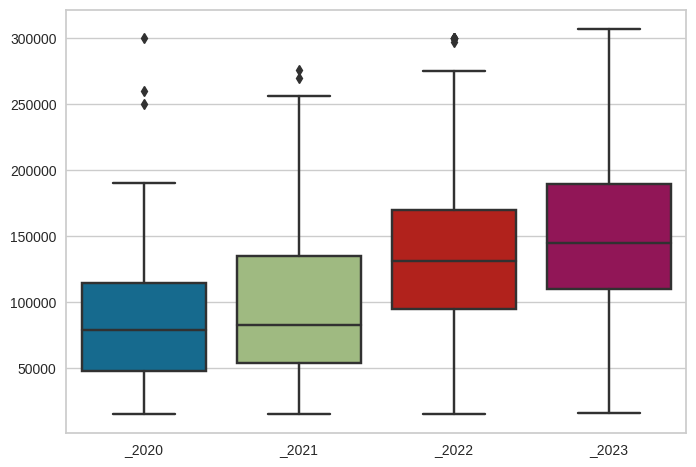

In [ ]:
# 2. Biểu diễn trực quan bằng Boxplot --> quan sát sự khác biệt giữa các nhóm
sns.boxplot(data = data)
plt.show()


In [ ]:
# 3. Phân tích ANOVA với alpha = 5%.
alpha = .05
# 3a) Kiểm định điều kiện _2020, _2021, _2022 có cùng phương sai (Levene)
print('''Các giả thuyết kiểm định LEVENE:
    H0: VAR(_2020) = VAR(_2021) = VAR(_2022) = VAR(_2023)
    Ha: Các phương sai KHÔNG BẰNG NHAU''')

levene, p = sp.stats.levene(_2020,_2021,_2022,_2023)
print(f'\nTrị thống kê Levene = {levene:4f}; p = {p:4f}')
if  p>alpha:
  print(f'p > alpha cho nên KHÔNG bác bỏ H0: VAR(_2020) = VAR(_2021) = VAR(_2022) = VAR(_2023)')
else:
  print(f'p < alpha cho nên bác bỏ H0 -> Các phương sai không bằng nhau.')

Các giả thuyết kiểm định LEVENE:
    H0: VAR(_2020) = VAR(_2021) = VAR(_2022) = VAR(_2023)
    Ha: Các phương sai KHÔNG BẰNG NHAU

Trị thống kê Levene = 2.803982; p = 0.038285
p < alpha cho nên bác bỏ H0 -> Các phương sai không bằng nhau.


In [ ]:
# 3b) Áp dụng One-way ANOVA
# Hàm f_oneway() chỉ trả về F-statistic và p-value, KHÔNG tạo ANOVA table
f, p = sp.stats.f_oneway(_2020, _2021, _2022, _2023)
print('H0: KHÔNG có sự khác biệt giữa lương qua các năm.')
print('Ha: Có sự khác biệt giữa lương qua các năm.\n')
if (p < alpha):
    print(f'* Trị số p = {p} < {alpha} cho nên bác bỏ H0 ==> có sự khác biệt giữa lương qua các năm')
else:
    print(f'* Trị số p = {p} >= {alpha} cho nên KHÔNG bác bỏ H0 ==> KHÔNG có sự khác biệt giữa lương qua các năm')
## p-value có ý nghĩa về mặt thống kê (p < 0.05)


H0: KHÔNG có sự khác biệt giữa lương qua các năm.
Ha: Có sự khác biệt giữa lương qua các năm.

* Trị số p = 8.193496357672687e-77 < 0.05 cho nên bác bỏ H0 ==> có sự khác biệt giữa lương qua các năm


In [ ]:
## 3c) Hậu kiểm Tukey HSD
df_melt = pd.melt(data.reset_index(),
                  id_vars = ['index'],
                  value_vars = ['_2020', '_2021', '_2022','_2023'])
df_melt=df_melt.dropna()
df_melt.columns = ['index', 'work_year', 'value']  # tên các cột
model           = ols('value ~ C(work_year)', data = df_melt).fit()

m_comp = pairwise_tukeyhsd(endog  = df_melt['value'],
                           groups = df_melt['work_year'],
                           alpha  = 0.05)
print(m_comp)


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj     lower      upper    reject
-------------------------------------------------------------
 _2020  _2021  6937.8102 0.8134 -13236.3359 27111.9563  False
 _2020  _2022 42935.1331    0.0  25084.4126 60785.8536   True
 _2020  _2023 61226.5837    0.0   43661.886 78791.2815   True
 _2021  _2022 35997.3229    0.0  25266.5198 46728.1261   True
 _2021  _2023 54288.7735    0.0  44040.8215 64536.7256   True
 _2022  _2023 18291.4506    0.0  14208.2445 22374.6567   True
-------------------------------------------------------------


## III. Phân tích đa biến

### Work Year

In [ ]:
# work_year & salary_in_usd - lineplot
# Lineplot thể hiện trung bình lương theo các năm
salary_by_year = df.groupby('work_year')['salary_in_usd'].mean()

fig = px.line(df,
               x=salary_by_year.index.astype('str'),
               y=salary_by_year.values,
               text=np.round(salary_by_year.values,3),
               title='Trung bình lương theo năm')
fig.update_layout(
    xaxis=dict(
        title='Work year',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Trung bình lương (USD)',
        titlefont_size=16
    ),
    yaxis_range=[0, max(salary_by_year.values)]
)
fig.show()

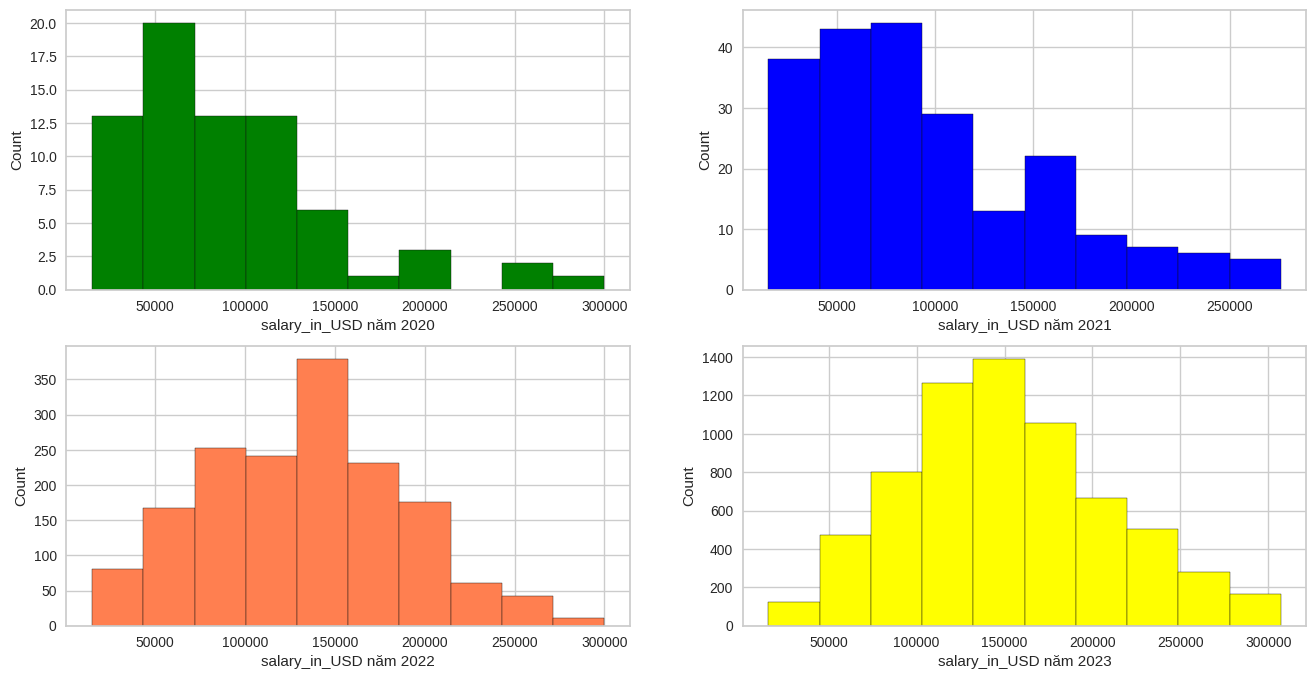

In [ ]:
# work_year & salary_in_usd - subplot, hist
# Biểu đồ tần số lương cho mỗi năm
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.hist(df[df['work_year']==2020]['salary_in_usd'],  density = False, color = 'green', edgecolor='k')
plt.xlabel('salary_in_USD năm 2020')
plt.ylabel('Count')

plt.subplot(2, 2, 2)
plt.hist(df[df['work_year']==2021]['salary_in_usd'],  density = False, color = 'blue', edgecolor='k')
plt.xlabel('salary_in_USD năm 2021')
plt.ylabel('Count')

plt.subplot(2, 2, 3)
plt.hist(df[df['work_year']==2022]['salary_in_usd'],  density = False, color = 'coral', edgecolor='k')
plt.xlabel('salary_in_USD năm 2022')
plt.ylabel('Count')

plt.subplot(2, 2, 4)
plt.hist(df[df['work_year']==2023]['salary_in_usd'],  density = False, color = 'yellow', edgecolor='k')
plt.xlabel('salary_in_USD năm 2023')
plt.ylabel('Count')

plt.show()

### Experience Level

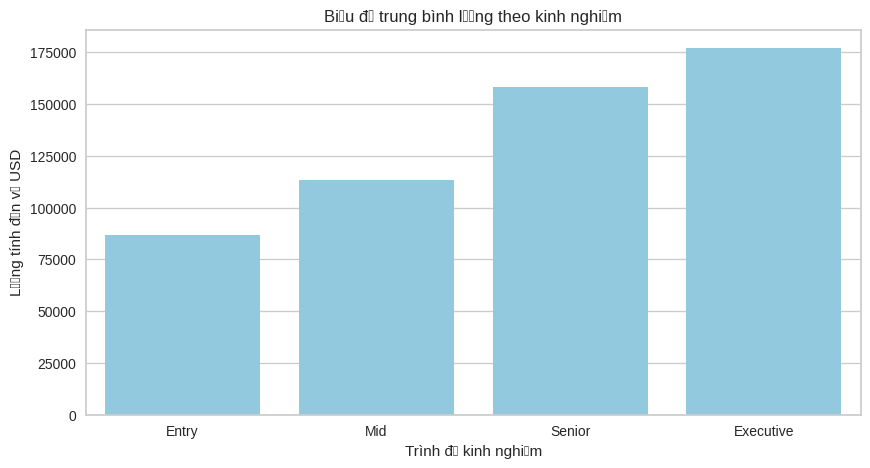

In [ ]:
# experience_level & salary_in_usd - subplot, hist
experience_level_order = ['Entry', 'Mid', 'Senior', 'Executive']

# experience_level & salary_in_usd
# Biểu đồ trung bình lương theo kinh nghiệm
data = df.groupby('experience_level')['salary_in_usd'].mean()

plt.figure(figsize=(10,5))
ax = sns.barplot(x=data.index, y=data.values, order=experience_level_order, color='skyblue')
ax.set_xlabel('Trình độ kinh nghiệm')
ax.set_ylabel('Lương tính đơn vị USD')
ax.set_title('Biểu đồ trung bình lương theo kinh nghiệm')

plt.show()

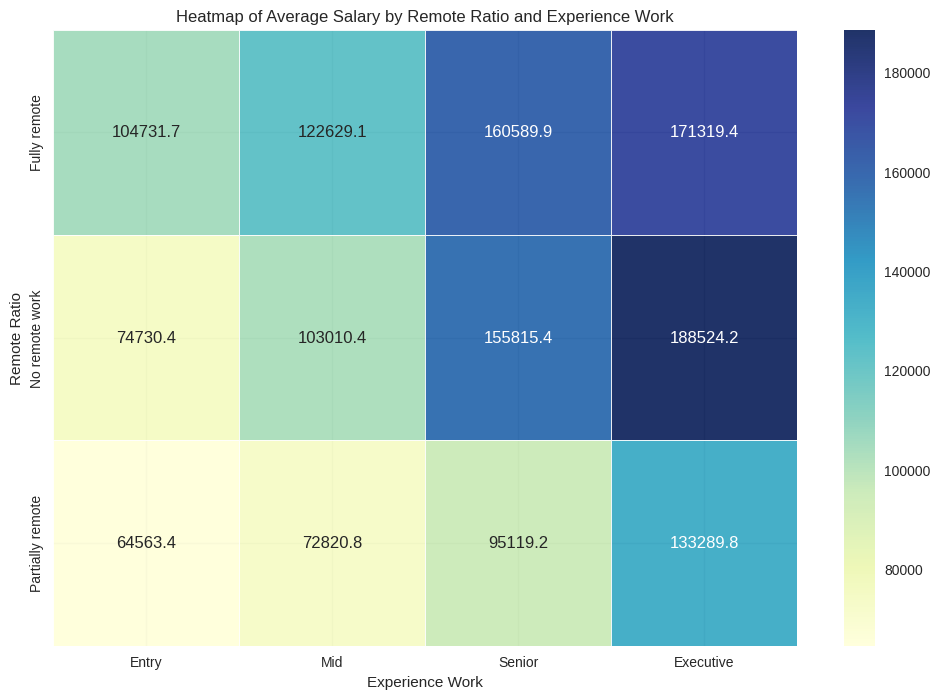

In [ ]:
## Heatmap of Average Salary by Job and Experience Work
average_salary_experience = df.groupby(['experience_level','remote_ratio'])[['salary_in_usd']].mean().reset_index()
average_salary_experience['experience_level'] = pd.Categorical(average_salary_experience['experience_level'], categories=experience_level_order, ordered=True)
average_salary_experience = average_salary_experience.sort_values(by='experience_level')

heatmap_data = average_salary_experience.pivot('remote_ratio', 'experience_level', 'salary_in_usd')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".1f",
            linewidths=0.5, alpha = 0.9)

plt.title('Heatmap of Average Salary by Remote Ratio and Experience Work')
plt.xlabel('Experience Work')
plt.ylabel('Remote Ratio')
plt.show()

### Job Title

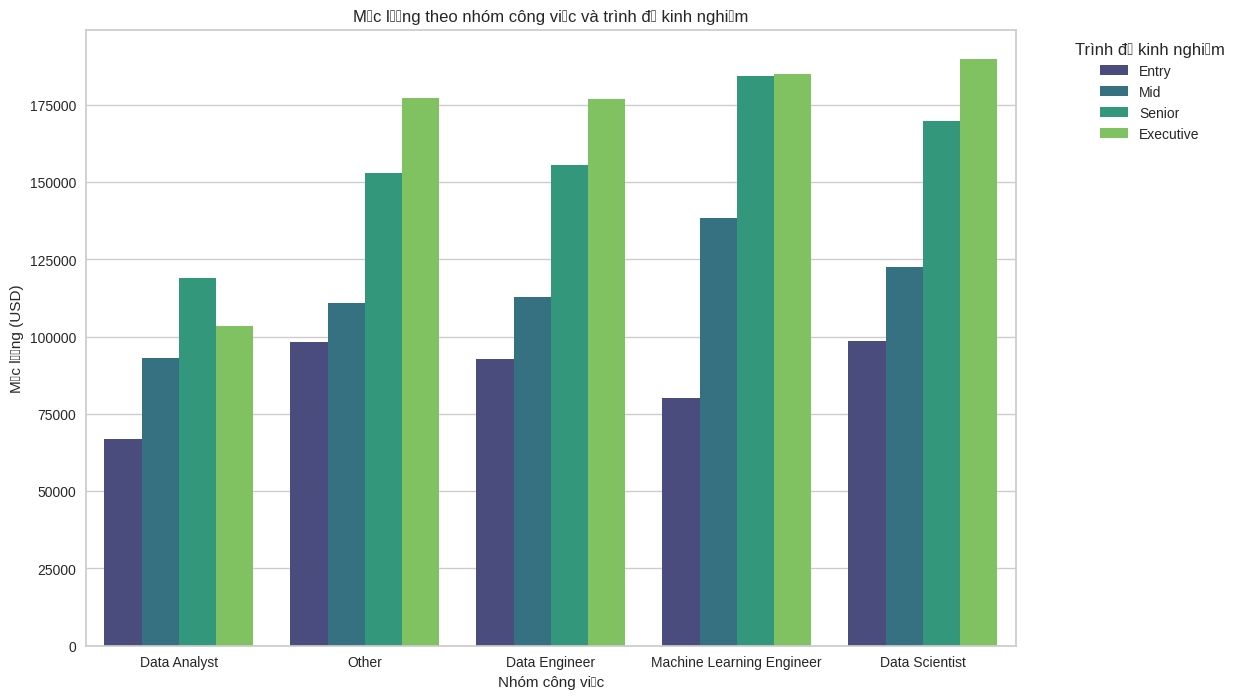

In [ ]:
# Tính mức lương trung bình cho mỗi nhóm công việc và trình độ kinh nghiệm
salary_by_experience = df.groupby(['job_title_clean', 'experience_level'])['salary_in_usd'].mean().reset_index()
salary_by_experience['experience_level'] = pd.Categorical(salary_by_experience['experience_level'], categories=experience_level_order, ordered=True)
salary_by_experience = salary_by_experience.sort_values(by='experience_level')


# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
sns.barplot(x='job_title_clean', y='salary_in_usd', hue='experience_level', data=salary_by_experience, palette='viridis')
plt.title('Mức lương theo nhóm công việc và trình độ kinh nghiệm')
plt.xlabel('Nhóm công việc')
plt.ylabel('Mức lương (USD)')
plt.legend(title='Trình độ kinh nghiệm', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Company Size

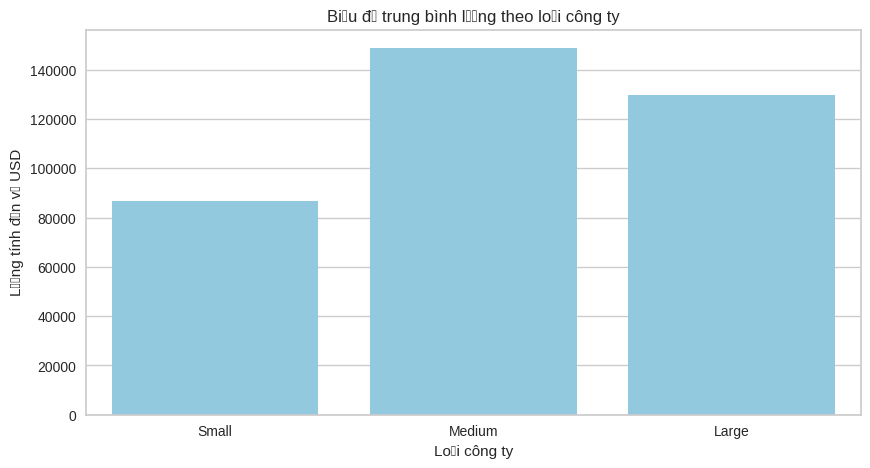

In [ ]:
company_size_order = ['Small', 'Medium', 'Large']

# Biểu đồ trung bình lương theo loại công ty
data = df.groupby('company_size')['salary_in_usd'].mean()

plt.figure(figsize=(10,5))
ax = sns.barplot(x=data.index, y=data.values, order=company_size_order, color='skyblue')
ax.set_xlabel('Loại công ty')
ax.set_ylabel('Lương tính đơn vị USD')
ax.set_title('Biểu đồ trung bình lương theo loại công ty')

plt.show()

In [ ]:
# Company Size & Salary - boxplot
px.box(df,x='company_size',y='salary_in_usd',color='company_size',
       template='ggplot2',labels={'company_size':'company size',
                                  'salary_in_usd':'salary in usd'},
       title='<b>Data Science Salaries by Company Size',
       width=1000, height=600)

### Remote Ratio

In [ ]:
## Boxplot of salary_in_usd by Remote ratio
px.box(df,x='remote_ratio',y='salary_in_usd',color='remote_ratio',
       template='seaborn',labels={'remote_ratio':'Remove Ratio',
                                  'salary_in_usd':'salary in usd'},
       title='<b>Data Science Salaries by Remove Ratio',
       width=1000, height=600)

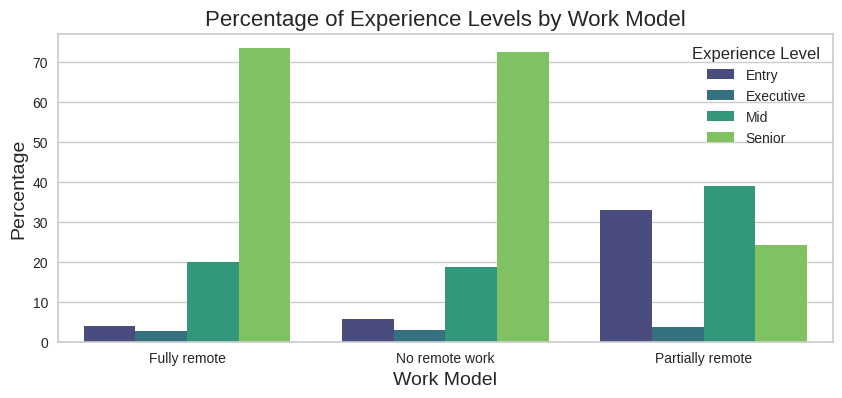

In [ ]:
# Nhóm dữ liệu theo mô hình công việc và mức độ kinh nghiệm, tính toán số lượng cho mỗi kết hợp
grouped_data = df.groupby(['remote_ratio', 'experience_level']).size().reset_index(name='count')

# Tính tổng số cho từng mô hình công việc để tìm tỷ lệ phần trăm sau này
total_counts = grouped_data.groupby('remote_ratio')['count'].sum().reset_index(name='total_count')

# Merging the total counts back into the grouped data
merged_data = pd.merge(grouped_data, total_counts, on='remote_ratio')

# Calculating the percentage of each experience level for each work model
merged_data['percentage'] = (merged_data['count'] / merged_data['total_count']) * 100


# Plotting the percentage of experience levels for each work model
plt.figure(figsize=(10,4))

sns.barplot(data=merged_data, x='remote_ratio', y='percentage', hue='experience_level', palette='viridis')

plt.title('Percentage of Experience Levels by Work Model', fontsize=16)
plt.ylabel('Percentage', fontsize=14)
plt.xlabel('Work Model', fontsize=14)
plt.tick_params(axis='x')
plt.legend(title='Experience Level')
plt.show()

### Company Location

In [ ]:
average_salary_by_company = df.groupby('company_location')['salary_in_usd'].mean().reset_index()
fig = px.choropleth(locations=average_salary_by_company['company_location'],
                    color=average_salary_by_company['salary_in_usd'],
                    color_continuous_scale=px.colors.sequential.YlGn,
                    # template='plotly_dark',
                    title = 'Biểu đồ địa lý mức lương theo company_location')

fig.update_layout(font = dict(size= 17, family="Segoe UI"))
fig.show()

## IV. Thu gọn dữ liệu

In [ ]:
# Bỏ cột employment_type vì cột này biến thiên quá ít
df.drop(df[['employment_type']],axis=1, inplace=True)
# Bỏ cột employee_residence vì cột này tương quan với cột company_location
df.drop(df[['employee_residence']],axis=1, inplace=True)

## V. Chuyển dạng dữ liệu

In [ ]:
# Giữ lại df gốc
df_pre = df.drop(df[['remote_ratio_clean','job_title']],axis =1).reset_index(drop = True)

In [ ]:
# company_location
def location(title):
    if any(keyword in title.lower() for keyword in ['usa']):
      return 1
    else:
        return 0
df['usa'] = df['company_location'].apply(location)

In [ ]:
# Company size
mapping_dict = {'Small': 1, 'Medium': 2, 'Large': 3}
df['company_size_clean'] = df['company_size'].map(mapping_dict)

In [ ]:
# experience_level
mapping_dict = {'Entry': 1, 'Mid': 2, 'Senior': 3, 'Executive': 4}
df['experience_level_clean'] = df['experience_level'].map(mapping_dict)

In [ ]:
# loại bỏ những cột đã được thay bằng cột mới
df.drop(df[['experience_level', 'job_title', 'remote_ratio', 'company_location', 'company_size']],axis=1, inplace = True)

In [ ]:
df.reset_index(drop = True, inplace = True)

### Cho mô hình rừng ngẫu nhiên

In [ ]:
# job_title_clean cho mô hình rừng ngẫu nhiên
enc            = LabelEncoder()
job_title_rd  = pd.Series(enc.fit_transform(df['job_title_clean']))
job_title_rd  = pd.DataFrame(job_title_rd, columns = ['job_title_rd'])
print(job_title_rd)

## Bảng mã
print(job_title_rd.nunique())
mappings = {index: label for index, label in enumerate(enc.classes_)}
print(mappings)

      job_title_rd
0                2
1                2
2                4
3                4
4                3
...            ...
8641             4
8642             2
8643             2
8644             0
8645             2

[8646 rows x 1 columns]
job_title_rd    5
dtype: int64
{0: 'Data Analyst', 1: 'Data Engineer', 2: 'Data Scientist', 3: 'Machine Learning Engineer', 4: 'Other'}


In [ ]:
df_rd  = pd.concat([df, job_title_rd], axis = 1)
df_rd.drop(df_rd[['job_title_clean']],axis=1, inplace = True)

#### Chuẩn hoá dữ liệu

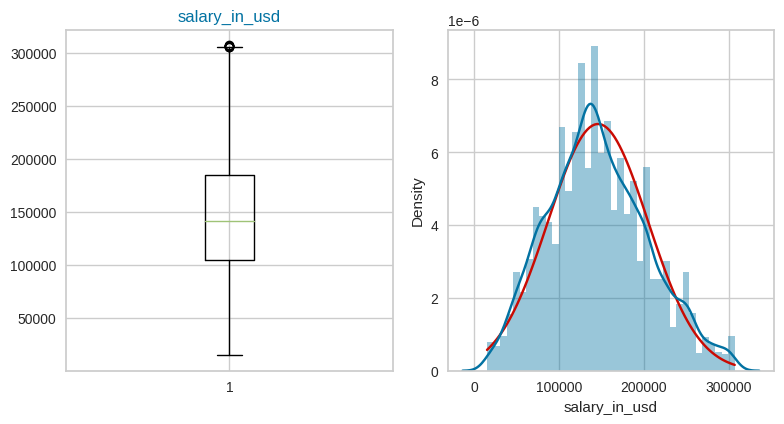

In [ ]:
# Kiểm tra KHÔNG có phân phối CHUẨN, KHÔNG có outliers
fig = plt.figure(figsize = ([8, 8]))

plt.subplot(2, 2, 1)
plt.title('salary_in_usd', color = 'b')
plt.boxplot(df['salary_in_usd'])

plt.subplot(2, 2, 2)
# Tính mean và standard deviation của dữ liệu
mean, std_dev = np.mean(df['salary_in_usd']), np.std(df['salary_in_usd'])

# Tạo dải giá trị để vẽ đường phân phối chuẩn
x_range = np.linspace(min(df['salary_in_usd']), max(df['salary_in_usd']), 100)
normal_distribution = norm.pdf(x_range, mean, std_dev)

# Vẽ đường phân phối chuẩn
plt.plot(x_range, normal_distribution, 'r', label='Normal Distribution')

sns.distplot(df['salary_in_usd'], kde = True, hist = True)

plt.tight_layout()
plt.show()

In [ ]:
# Kiểm định shapiro phân phối chuẩn
statistic, p_value = shapiro(df['salary_in_usd'])

# In kết quả
print(f'Statistic: {statistic}, p-value: {p_value}')

# Kiểm tra giả định null
if p_value > 0.05:
    print('Không có bằng chứng để bác bỏ giả định null.')
else:
    print('Bác bỏ giả định null, mẫu dữ liệu không tuân theo phân phối chuẩn.')

Statistic: 0.9901731610298157, p-value: 5.226472893088336e-24
Bác bỏ giả định null, mẫu dữ liệu không tuân theo phân phối chuẩn.


In [ ]:
## Chuẩn hóa dữ liệu MinMaxScaler() vì không có phân phối chuẩn và outliers
scaler       = MinMaxScaler()
MinMax_array = scaler.fit_transform(df_rd) # dạng array
df_rd    = pd.DataFrame(MinMax_array, columns = df_rd.columns)
df_rd

,work_year,salary_in_usd,remote_ratio_clean,usa,company_size_clean,experience_level_clean,job_title_rd
0,1.000000,0.674427,0.0,1.0,0.5,1.000000,0.50
1,1.000000,0.599110,0.0,1.0,0.5,1.000000,0.50
2,1.000000,0.096077,0.0,0.0,0.5,0.333333,1.00
3,1.000000,0.096077,0.0,0.0,0.5,0.333333,1.00
4,1.000000,0.789798,0.0,1.0,0.5,0.666667,0.75
...,...,...,...,...,...,...,...
8641,0.333333,0.513523,1.0,1.0,1.0,0.666667,1.00
8642,0.333333,0.465594,1.0,1.0,1.0,0.333333,0.50
8643,0.000000,0.308114,1.0,1.0,0.0,0.000000,0.50
8644,0.000000,0.290996,1.0,1.0,1.0,0.000000,0.00


In [ ]:
# Xuất file kết quả cho mô hình random forest
df_rd.to_csv('/content/df_rd.csv')
df_rd

,work_year,salary_in_usd,remote_ratio_clean,usa,company_size_clean,experience_level_clean,job_title_rd
0,1.000000,0.674427,0.0,1.0,0.5,1.000000,0.50
1,1.000000,0.599110,0.0,1.0,0.5,1.000000,0.50
2,1.000000,0.096077,0.0,0.0,0.5,0.333333,1.00
3,1.000000,0.096077,0.0,0.0,0.5,0.333333,1.00
4,1.000000,0.789798,0.0,1.0,0.5,0.666667,0.75
...,...,...,...,...,...,...,...
8641,0.333333,0.513523,1.0,1.0,1.0,0.666667,1.00
8642,0.333333,0.465594,1.0,1.0,1.0,0.333333,0.50
8643,0.000000,0.308114,1.0,1.0,0.0,0.000000,0.50
8644,0.000000,0.290996,1.0,1.0,1.0,0.000000,0.00


### Cho mô hình hồi quy tuyến tính và SVM



In [ ]:
# job_title_clean cho mô hình hồi quy và svm
job_title_lr_svm = pd.get_dummies(df['job_title_clean'])
job_title_lr_svm.drop(job_title_lr_svm[['Other']],axis=1, inplace = True)

In [ ]:
# Ghép bộ dữ liệu gốc với cột job_title được dummy và bỏ đi dư thừa
df_lr_svm  = pd.concat([df, job_title_lr_svm], axis = 1)
df_lr_svm.drop(df_lr_svm[['job_title_clean']],axis=1, inplace = True)

#### Chuẩn hoá dữ liệu

In [ ]:
## Chuẩn hóa dữ liệu MinMaxScaler() vì không có phân phối chuẩn và outliers
scaler       = MinMaxScaler()
MinMax_array = scaler.fit_transform(df_lr_svm) # dạng array
df_lr_svm    = pd.DataFrame(MinMax_array, columns = df_lr_svm.columns)
df_lr_svm

,work_year,salary_in_usd,remote_ratio_clean,usa,company_size_clean,experience_level_clean,Data Analyst,Data Engineer,Data Scientist,Machine Learning Engineer
0,1.000000,0.674427,0.0,1.0,0.5,1.000000,0.0,0.0,1.0,0.0
1,1.000000,0.599110,0.0,1.0,0.5,1.000000,0.0,0.0,1.0,0.0
2,1.000000,0.096077,0.0,0.0,0.5,0.333333,0.0,0.0,0.0,0.0
3,1.000000,0.096077,0.0,0.0,0.5,0.333333,0.0,0.0,0.0,0.0
4,1.000000,0.789798,0.0,1.0,0.5,0.666667,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
8641,0.333333,0.513523,1.0,1.0,1.0,0.666667,0.0,0.0,0.0,0.0
8642,0.333333,0.465594,1.0,1.0,1.0,0.333333,0.0,0.0,1.0,0.0
8643,0.000000,0.308114,1.0,1.0,0.0,0.000000,0.0,0.0,1.0,0.0
8644,0.000000,0.290996,1.0,1.0,1.0,0.000000,1.0,0.0,0.0,0.0


In [ ]:
# Xuất file kết quả cho mô hình hồi quy và svm chưa giảm chiều
df_lr_svm.to_csv('/content/df_lr_svm.csv')

#### PCA cho mô hình hồi quy tuyến tính và SVM

In [ ]:
## Mô tả dữ liệu
## Biến phân lớp (target variable): 'Class' --> cột cuối cùng trong file
target = 'salary_in_usd'
print('* Biến phân lớp:', target)

## Danh sách các features
nb_features = df_lr_svm.shape[1] - 1
features    = df_lr_svm.drop(target, axis=1).columns
print('* Số lượng features = %2d' %nb_features)
print('  Các features:', ', '.join(features))

* Biến phân lớp: salary_in_usd
* Số lượng features =  9
  Các features: work_year, remote_ratio_clean, usa, company_size_clean, experience_level_clean, Data Analyst, Data Engineer, Data Scientist, Machine Learning Engineer


In [ ]:
features

Index(['work_year', 'remote_ratio_clean', 'usa', 'company_size_clean',
       'experience_level_clean', 'Data Analyst', 'Data Engineer',
       'Data Scientist', 'Machine Learning Engineer'],
      dtype='object')

In [ ]:
## Áp dụng PCA (chưa xác định k --> giữ nguyên số chiều)
pca = PCA().fit(df_lr_svm[features])

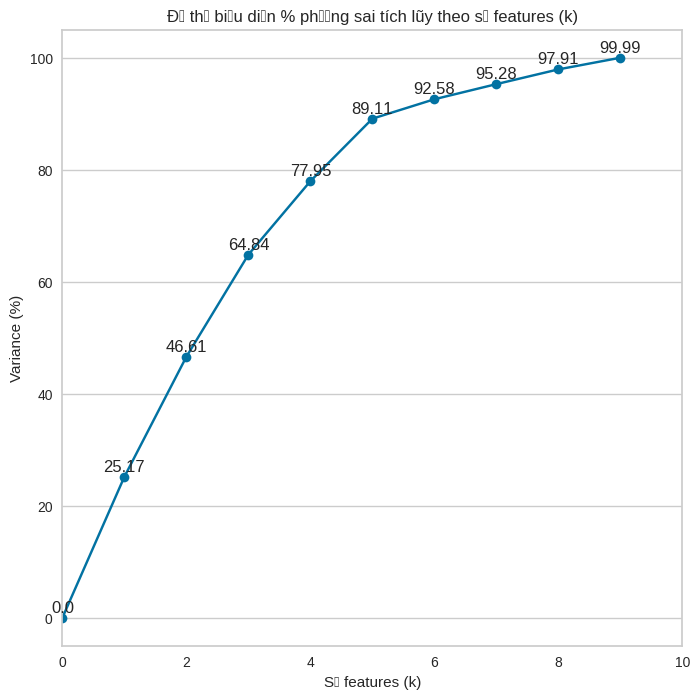

In [ ]:
## Vẽ đồ thị biểu diễn % phương sai tích lũy theo số features --> chọn k theo điểm "gẫy"
points = np.cumsum(pca.explained_variance_ratio_) * 100 # Các điểm dữ liệu
points = np.insert(points, 0, 0) # Thêm điểm k = 0, variance = 0
x_i = np.arange(0, nb_features + 1)
y_i = (points[-13:])//0.01/100

plt.figure(figsize = (8, 8))
plt.plot(points, marker = 'o')
plt.xlabel('Số features (k)')
plt.ylabel('Variance (%)')
plt.title('Đồ thị biểu diễn % phương sai tích lũy theo số features (k)')
plt.xlim([0, nb_features + 1])
plt.grid(axis = 'x')
for i in x_i:
    plt.text(i, y_i[i] + 1, y_i[i], ha = 'center', va = 'baseline') # tung độ của text cao hơn point 1 đơn vị

plt.show()

In [ ]:
## Kiểm chứng: Tính phương sai tích lũy theo giá trị của k
var = 0.0
for k in range(1, nb_features + 1):
    pca = PCA(k)
    pca.fit(df_lr_svm[features])

    newVar = pca.explained_variance_ratio_.sum() * 100
    print('   * k = %2d' %k, ': phương sai tích lũy ~ %.2f%%' %newVar,
          '--> tăng ~ %.2f%%' %(newVar - var))
    var = newVar

   * k =  1 : phương sai tích lũy ~ 25.18% --> tăng ~ 25.18%
   * k =  2 : phương sai tích lũy ~ 46.61% --> tăng ~ 21.44%
   * k =  3 : phương sai tích lũy ~ 64.84% --> tăng ~ 18.23%
   * k =  4 : phương sai tích lũy ~ 77.96% --> tăng ~ 13.12%
   * k =  5 : phương sai tích lũy ~ 89.12% --> tăng ~ 11.16%
   * k =  6 : phương sai tích lũy ~ 92.59% --> tăng ~ 3.47%
   * k =  7 : phương sai tích lũy ~ 95.29% --> tăng ~ 2.70%
   * k =  8 : phương sai tích lũy ~ 97.92% --> tăng ~ 2.63%
   * k =  9 : phương sai tích lũy ~ 100.00% --> tăng ~ 2.08%


* Chọn k = 6

In [ ]:
## Thực hiện PCA với k = 6
k   = 6
pca = PCA(k)
pca.fit(df_lr_svm[features])

PCA(n_components=6)

In [ ]:
## Chiếu dữ liệu vào không gian mới (Transform data)
PC_name = []
for i in range(k):
  name = f'Principal Component {i+1}'
  PC_name.append(name)
P           = pca.transform(df_lr_svm[features])
principalDf_lr_svm = pd.DataFrame(data = P, columns = PC_name)

In [ ]:
df_lr_svm_pca  = pd.concat([principalDf_lr_svm, df_lr_svm['salary_in_usd']], axis = 1)

In [ ]:
# Xuất file kết quả cho mô hình hồi quy và svm đã giảm chiều
df_lr_svm_pca.to_csv('/content/df_lr_svm_pca.csv')
df_lr_svm_pca

,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Principal Component 5,Principal Component 6,salary_in_usd
0,0.692303,-0.511517,-0.122474,-0.122468,-0.156623,-0.352753,0.674427
1,0.692303,-0.511517,-0.122474,-0.122468,-0.156623,-0.352753,0.599110
2,-0.104217,-0.240063,0.178701,0.194139,0.889088,-0.082022,0.096077
3,-0.104217,-0.240063,0.178701,0.194139,0.889088,-0.082022,0.096077
4,-0.205225,-0.420525,0.374262,0.836680,-0.230115,-0.016253,0.789798
...,...,...,...,...,...,...,...
8641,-0.017115,0.624865,-0.038075,0.107946,-0.185831,0.161137,0.513523
8642,0.794612,0.529516,-0.304791,-0.062577,-0.086642,0.523027,0.465594
8643,0.770422,0.576648,-0.292404,-0.066863,-0.011035,0.802182,0.308114
8644,-0.161960,0.868973,0.629439,-0.408544,0.060526,0.886747,0.290996


### Tiền xử lí cho mô hình phân cụm

#### PCA cho mô hình phân cụm

In [ ]:
## Mô tả dữ liệu
df_km_hac = df_lr_svm.copy()
## Phân cụm không sử dụng biến target
## Danh sách các features
nb_features = df_km_hac.shape[1]
features    = df_km_hac.columns
print('* Số lượng features = %2d' %nb_features)
print('  Các features:', ', '.join(features))

* Số lượng features = 10
  Các features: work_year, salary_in_usd, remote_ratio_clean, usa, company_size_clean, experience_level_clean, Data Analyst, Data Engineer, Data Scientist, Machine Learning Engineer


In [ ]:
## Áp dụng PCA (chưa xác định k --> giữ nguyên số chiều)
pca = PCA().fit(df_km_hac[features])

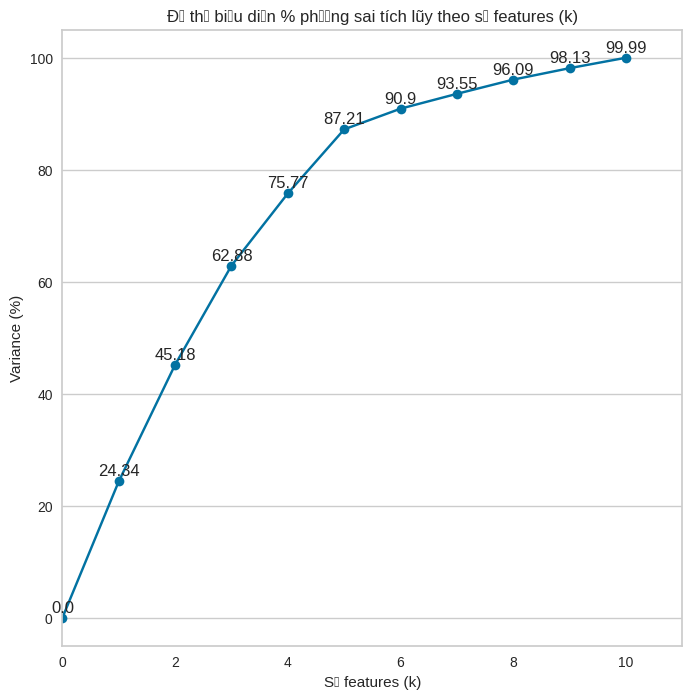

In [ ]:
## Vẽ đồ thị biểu diễn % phương sai tích lũy theo số features --> chọn k theo điểm "gẫy"
points = np.cumsum(pca.explained_variance_ratio_) * 100 # Các điểm dữ liệu
points = np.insert(points, 0, 0) # Thêm điểm k = 0, variance = 0
x_i = np.arange(0, nb_features + 1)
y_i = (points[-13:])//0.01/100

plt.figure(figsize = (8, 8))
plt.plot(points, marker = 'o')
plt.xlabel('Số features (k)')
plt.ylabel('Variance (%)')
plt.title('Đồ thị biểu diễn % phương sai tích lũy theo số features (k)')
plt.xlim([0, nb_features + 1])
plt.grid(axis = 'x')
for i in x_i:
    plt.text(i, y_i[i] + 1, y_i[i], ha = 'center', va = 'baseline') # tung độ của text cao hơn point 1 đơn vị

plt.show()

In [ ]:
## Kiểm chứng: Tính phương sai tích lũy theo giá trị của k
var = 0.0
for k in range(1, nb_features + 1):
    pca = PCA(k)
    pca.fit(df_km_hac[features])

    newVar = pca.explained_variance_ratio_.sum() * 100
    print('   * k = %2d' %k, ': phương sai tích lũy ~ %.2f%%' %newVar,
          '--> tăng ~ %.2f%%' %(newVar - var))
    var = newVar

   * k =  1 : phương sai tích lũy ~ 24.35% --> tăng ~ 24.35%
   * k =  2 : phương sai tích lũy ~ 45.18% --> tăng ~ 20.83%
   * k =  3 : phương sai tích lũy ~ 62.89% --> tăng ~ 17.70%
   * k =  4 : phương sai tích lũy ~ 75.77% --> tăng ~ 12.89%
   * k =  5 : phương sai tích lũy ~ 87.21% --> tăng ~ 11.44%
   * k =  6 : phương sai tích lũy ~ 90.90% --> tăng ~ 3.69%
   * k =  7 : phương sai tích lũy ~ 93.55% --> tăng ~ 2.65%
   * k =  8 : phương sai tích lũy ~ 96.09% --> tăng ~ 2.54%
   * k =  9 : phương sai tích lũy ~ 98.14% --> tăng ~ 2.05%
   * k = 10 : phương sai tích lũy ~ 100.00% --> tăng ~ 1.86%


* Chọn k = 6

In [ ]:
## Thực hiện PCA với k = 6
k   = 6
pca = PCA(k)
pca.fit(df_km_hac[features])

PCA(n_components=6)

In [ ]:
## Chiếu dữ liệu vào không gian mới (Transform data)
PC_name = []
for i in range(k):
  name = f'Principal Component {i+1}'
  PC_name.append(name)
P           = pca.transform(df_km_hac[features])
df_km_hac_pca = pd.DataFrame(data = P, columns = PC_name)

In [ ]:
# Xuất file kết quả cho mô hình hồi quy và svm đã giảm chiều
df_km_hac_pca.to_csv('/content/df_km_hac_pca.csv')
df_km_hac_pca

,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Principal Component 5,Principal Component 6
0,0.719852,-0.516875,-0.110809,-0.075257,-0.198858,-0.362722
1,0.715500,-0.509512,-0.103909,-0.088494,-0.180407,-0.331234
2,-0.128909,-0.180942,0.246076,-0.064220,0.964890,-0.006685
3,-0.128909,-0.180942,0.246076,-0.064220,0.964890,-0.006685
4,-0.170667,-0.461942,0.330709,0.918387,-0.090053,-0.085494
...,...,...,...,...,...,...
8641,-0.026220,0.606789,-0.082945,0.173445,-0.182852,0.128059
8642,0.783618,0.538245,-0.317691,-0.053520,-0.081408,0.451412
8643,0.747364,0.603831,-0.289059,-0.104188,0.032348,0.778523
8644,-0.204256,0.908782,0.609607,-0.378532,-0.065085,0.726479


#### PCA  để biểu diễn phân cụm

In [ ]:
## Thực hiện PCA với k = 2
k   = 2
pca = PCA(k)
pca.fit(df_km_hac_pca)

PCA(n_components=2)

In [ ]:
## Chiếu dữ liệu vào không gian mới (Transform data)
PC_name = []
for i in range(k):
  name = f'Principal Component {i+1}'
  PC_name.append(name)
P           = pca.transform(df_km_hac_pca)
df_km_hac_pca_vs = pd.DataFrame(data = P, columns = PC_name)
df_km_hac_pca_vs

,Principal Component 1,Principal Component 2
0,0.719852,-0.516875
1,0.715500,-0.509512
2,-0.128909,-0.180942
3,-0.128909,-0.180942
4,-0.170667,-0.461942
...,...,...
8641,-0.026220,0.606789
8642,0.783618,0.538245
8643,0.747364,0.603831
8644,-0.204256,0.908782


# Chương 4. Xây dựng mô hình

## Phân cụm

### Kmeans

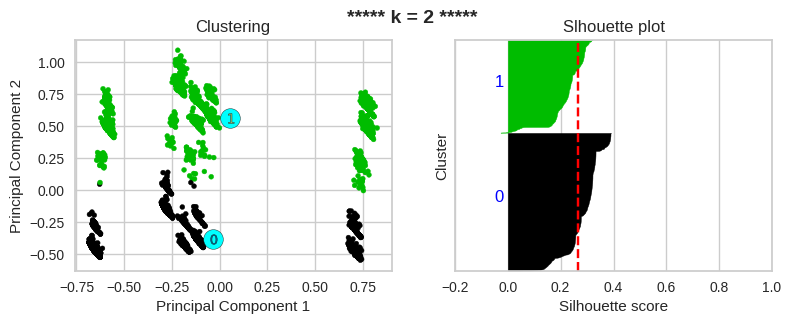

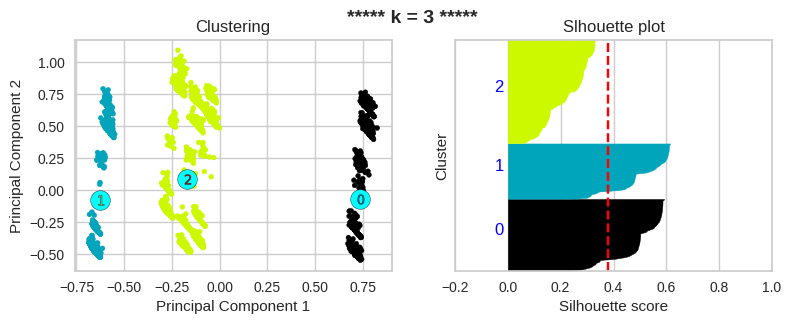

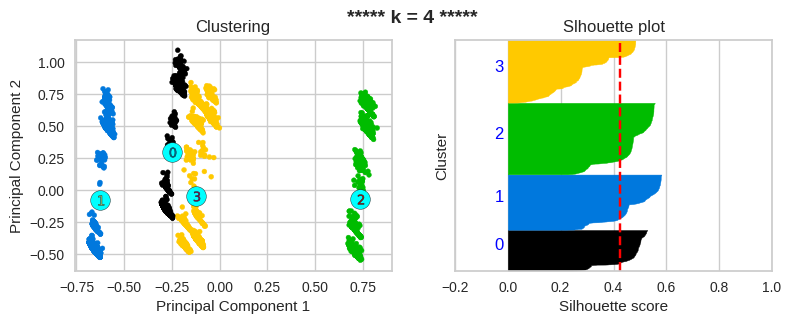

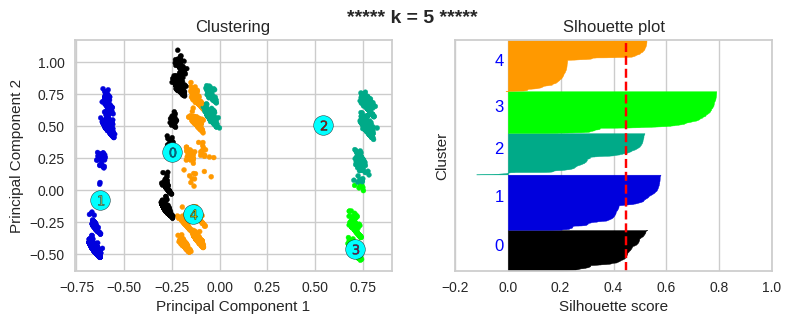

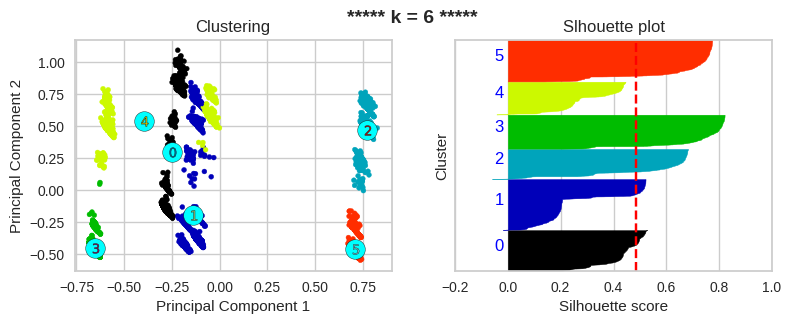

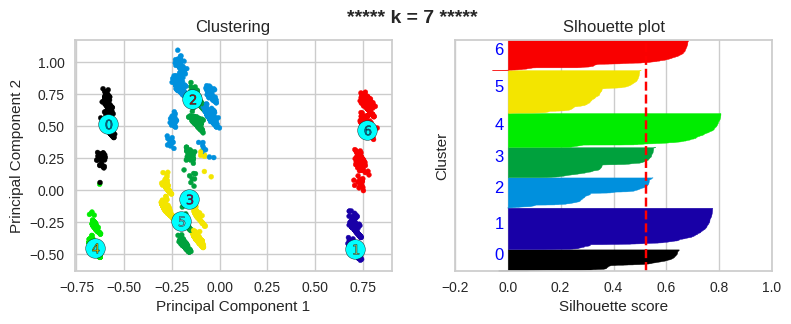

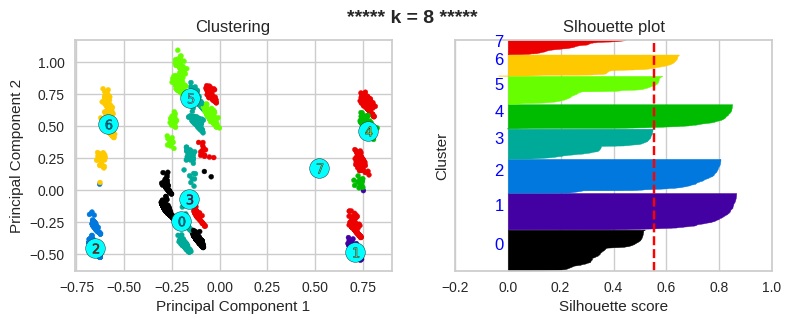

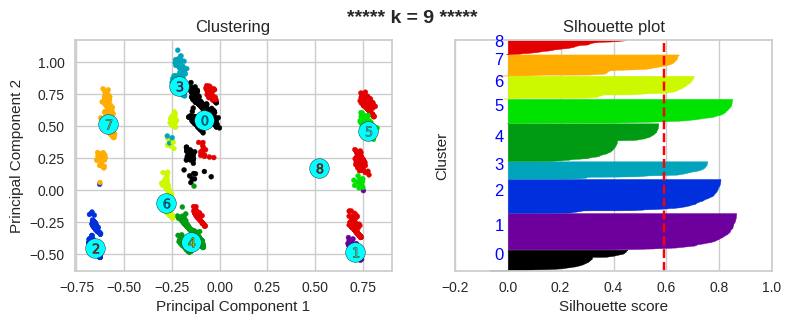

In [ ]:
silhouettes = []
nbClusters = range(2, 10)
for k in nbClusters:
    model = KMeans(n_clusters = k)
    model.fit(df_km_hac_pca)
    silhouettes.append(silhouette_score(df_km_hac_pca, model.fit_predict(df_km_hac_pca), metric = 'euclidean'))

## Biểu diễn trực quan clustering và phân tích silhouette scores theo tham số k
xmin       = min(silhouettes) # kết quả nhận được từ phía trên

for k in nbClusters:
    # Thực hiện kMeans với tham số k
    model_km  = KMeans(n_clusters = k)
    model_km.fit(df_km_hac_pca)
    labels = model_km.fit_predict(df_km_hac_pca) # nhãn của clusters

    # Biểu diễn trực quan
    fig, (ax1, ax2) = plt.subplots(1, 2) # ax1: scatter plot; ax2: Silhouette plot
    fig.set_size_inches(9, 3)

    ax1.set_title('Clustering')
    ax1.set_xlabel('Principal Component 1')
    ax1.set_ylabel('Principal Component 2')
    colors = plt.cm.nipy_spectral(labels.astype(float) / k) # phổ mầu cho clusters
    ax1.scatter(df_km_hac_pca_vs['Principal Component 1'], df_km_hac_pca_vs['Principal Component 2'], marker = '.', c = colors)

    # Các trọng tâm
    centroids = model_km.cluster_centers_
    ax1.scatter(centroids[:, 0], centroids[:, 1],
                marker = 'o', c = 'cyan', alpha = 1, s = 200, edgecolor = 'k')
    for i, center in enumerate(centroids):
        ax1.scatter(center[0], center[1],
                    marker = '$%d$' % i, alpha = 1, s = 50, edgecolor = 'k')

    # Silhouette trung bình cho tất cả samples
    silhouette_avg = silhouette_score(df_km_hac_pca, labels)

    # Silhouette scores cho mỗi sample (data point) xi
    silhouettes_samples = silhouette_samples(df_km_hac_pca, labels)

    # Silhouette plot
    ax2.set_xlim([xmin, 1])
    ax2.set_ylim([0, len(df_km_hac_pca) + (k + 1) * 10])
    ax2.set_title('Slhouette plot')
    ax2.set_xlabel('Silhouette score')
    ax2.set_ylabel('Cluster')

    # Vạch đứng đứt nét thể hiện Silouette trung bình
    ax2.axvline(x = silhouette_avg, color = 'red', linestyle = '--')

    ax2.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax2.set_yticks([])  # Xóa ticks trên trục tung

    # Vẽ silhouette scores cho từng cluster Ci
    y_lower = 10 # tung độ bắt đầu vẽ
    for Ci in range(k):
        # Silhouette scores của các samples trong cluster Ci (sắp xếp giảm dần)
        silhouette_Ci = silhouettes_samples[labels == Ci]
        silhouette_Ci.sort()

        size_Ci = silhouette_Ci.shape[0]
        y_upper = y_lower + size_Ci # tung độ kết thúc của Ci

        # Vẽ các đường ngang thể hiện silhouette scores của Ci
        color = cm.nipy_spectral(float(Ci) / k) # phổ mầu
        ax2.fill_betweenx(np.arange(y_lower, y_upper), 0, silhouette_Ci,
                          facecolor = color, edgecolor = color)

        # Hiện label của cluster Ci ở phía bên trái
        ax2.text(-0.05, y_lower + 0.5 * size_Ci, str(Ci), color = 'blue')
        plt.suptitle(f'***** k = {k} *****', fontsize = 14, fontweight = 'bold')

        # Tung độ cho cluster kế tiếp
        y_lower = y_upper + 10  # 10 là độ cách

plt.show()

In [ ]:
##----------------------- -------------------------------------------------------
## Thực hiện clustering bằng phương pháp KMeans
##------------------------------------------------------------------------------
k     = 4 # chọn k = 4 dựa trên đánh giá bằng silhoutte score
model_km = KMeans(n_clusters = k)
model_km.fit(df_km_hac_pca)

KMeans(n_clusters=4)

In [ ]:
## Các trọng tâm
print(f'*** {k} trọng tâm:')
print(model_km.cluster_centers_)

*** 4 trọng tâm:
[[ 0.73457154 -0.06840214 -0.1675631  -0.09281139  0.00984812  0.00644237]
 [-0.62879982 -0.07859973 -0.54430292 -0.14612286  0.01389453  0.0027938 ]
 [-0.24950896  0.29606826  0.74909044 -0.38279318 -0.08306995 -0.02402971]
 [-0.12302699 -0.04414209  0.18668708  0.48260579  0.03025401  0.00572764]]


In [ ]:
## Kết quả gom cụm
df_kmeans = df_km_hac_pca.copy()
df_kmeans['cluster'] = model_km.labels_
print(df_kmeans.head(10))

print('\nKích thước các clusters:')
print(df_kmeans['cluster'].value_counts())
print(f'Inertia / #samples = {model_km.inertia_/data.shape[0]:.2f}')

   Principal Component 1  Principal Component 2  Principal Component 3  \
0               0.719852              -0.516875              -0.110809   
1               0.715500              -0.509512              -0.103909   
2              -0.128909              -0.180942               0.246076   
3              -0.128909              -0.180942               0.246076   
4              -0.170667              -0.461942               0.330709   
5              -0.193102              -0.423990               0.366278   
6              -0.131924              -0.355556               0.218771   
7              -0.133902              -0.352209               0.221908   
8              -0.177334              -0.450663               0.341280   
9              -0.200818              -0.410937               0.378511   

   Principal Component 4  Principal Component 5  Principal Component 6  \
0              -0.075257              -0.198858              -0.362722   
1              -0.088494             

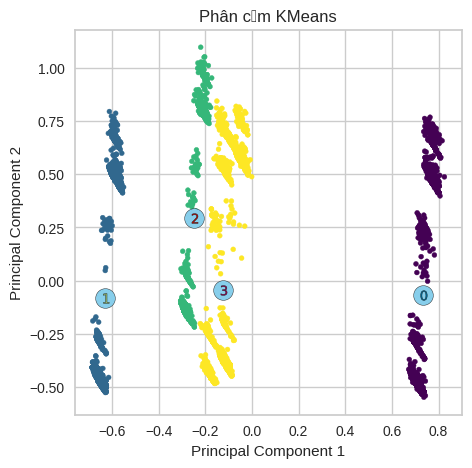

In [ ]:
# Biểu diễn trực quan
plt.figure(figsize = (5, 5))

plt.title('Phân cụm KMeans')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.scatter(df_km_hac_pca_vs['Principal Component 1'], df_km_hac_pca_vs['Principal Component 2'], marker = '.', c = df_kmeans['cluster'], cmap='viridis')

# # Các trọng tâm
centroids = model_km.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker = 'o', c = 'skyblue', alpha = 1, s = 200, edgecolor = 'k')
for i, center in enumerate(centroids):
    plt.scatter(center[0], center[1], marker = '$%d$' % i, alpha = 1, s = 50, edgecolor = 'k')
plt.show()

### HAC

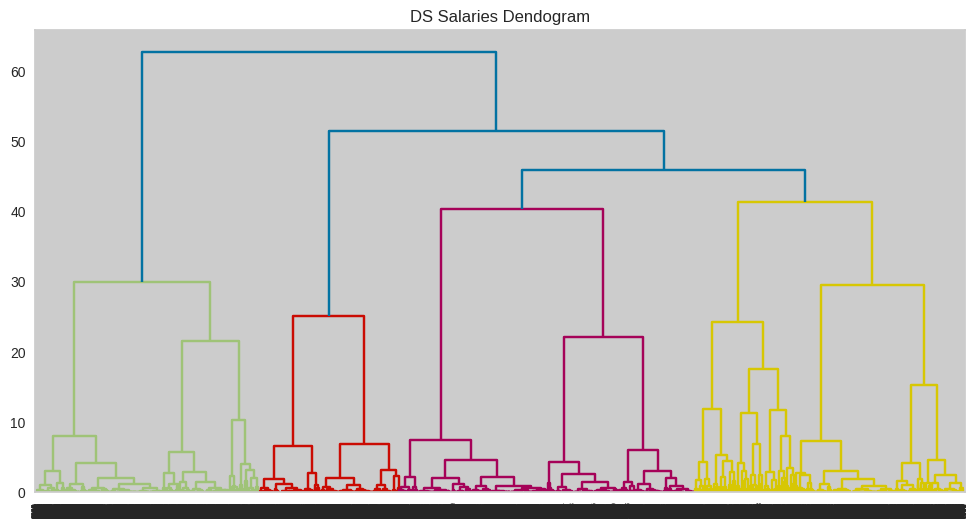

In [ ]:
##------------------------------------------------------------------------------
## Xây dụng Dendrogram
##------------------------------------------------------------------------------
plt.figure(figsize = (12, 6))
plt.title("DS Salaries Dendogram")
dg = hierarchy.dendrogram(hierarchy.linkage(df_km_hac_pca,
                                            method = 'ward'))


plt.axhline(y = 200, color = 'r', linestyle = '--')
plt.show()

In [ ]:
## Xây dựng mô hình AgglomerativeClustering
k     = 4
model_hac = AgglomerativeClustering(n_clusters = k, metric = 'euclidean', linkage = 'ward')
model_hac.fit(df_km_hac_pca)

AgglomerativeClustering(metric='euclidean', n_clusters=4)

In [ ]:
## Kết quả gom cụm
df_hac = df_km_hac_pca.copy()
df_hac['cluster'] = model_hac.labels_
print(df_hac.head(10))

print('\nKích thước các clusters:')
print(df_hac['cluster'].value_counts())

   Principal Component 1  Principal Component 2  Principal Component 3  \
0               0.719852              -0.516875              -0.110809   
1               0.715500              -0.509512              -0.103909   
2              -0.128909              -0.180942               0.246076   
3              -0.128909              -0.180942               0.246076   
4              -0.170667              -0.461942               0.330709   
5              -0.193102              -0.423990               0.366278   
6              -0.131924              -0.355556               0.218771   
7              -0.133902              -0.352209               0.221908   
8              -0.177334              -0.450663               0.341280   
9              -0.200818              -0.410937               0.378511   

   Principal Component 4  Principal Component 5  Principal Component 6  \
0              -0.075257              -0.198858              -0.362722   
1              -0.088494             

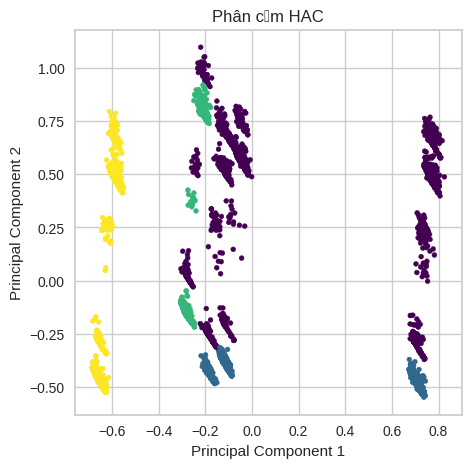

In [ ]:
# Biểu diễn trực quan
plt.figure(figsize = (5, 5))

plt.title('Phân cụm HAC')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.scatter(df_km_hac_pca_vs['Principal Component 1'], df_km_hac_pca_vs['Principal Component 2'], marker = '.', c = df_hac['cluster'], cmap='viridis')

plt.show()

### Đánh giá kết quả phân cụm

In [ ]:
# Tính toán Silhoutte Score để đánh giá hiệu năng của việc phân cụm
score_km = silhouette_score(df_km_hac_pca, model_km.labels_, metric='euclidean')
# Silhouette score nằm gần 1 nghĩa là ví dụ đang được phân cụm chính xác, xa các cụm khác
print('Silhouetter Score của KMean: %.3f' % score_km)

Silhouetter Score của KMean: 0.425


In [ ]:
# Tính toán Silhoutte Score để đánh giá hiệu năng của việc phân cụm
score_hac = silhouette_score(df_km_hac_pca, model_hac.labels_, metric='euclidean')
# Silhouette score nằm gần 1 nghĩa là ví dụ đang được phân cụm chính xác, xa các cụm khác
print('Silhouetter Score của HAC: %.3f' % score_hac)

Silhouetter Score của HAC: 0.364


* Vậy chọn mô hình KMeans

### Phân tích sau khi phân cụm

In [ ]:
df_cluster = df_pre.copy()
df_cluster['cluster'] = df_kmeans['cluster']

In [ ]:
df_cluster

,work_year,experience_level,salary_in_usd,remote_ratio,company_location,company_size,job_title_clean,cluster
0,2023,Executive,212000,Fully remote,USA,Medium,Data Scientist,0
1,2023,Executive,190000,Fully remote,USA,Medium,Data Scientist,0
2,2023,Mid,43064,Fully remote,GBR,Medium,Other,3
3,2023,Mid,43064,Fully remote,GBR,Medium,Other,3
4,2023,Senior,245700,Fully remote,USA,Medium,Machine Learning Engineer,3
...,...,...,...,...,...,...,...,...
8641,2021,Senior,165000,No remote work,USA,Large,Other,3
8642,2021,Mid,151000,No remote work,USA,Large,Data Scientist,0
8643,2020,Entry,105000,No remote work,USA,Small,Data Scientist,0
8644,2020,Entry,100000,No remote work,USA,Large,Data Analyst,2


####salary_in_usd

In [ ]:
# Tính các chỉ số liên quan trong phân phối mức lương trong từng cụm
summary_stats = df_cluster.groupby('cluster')['salary_in_usd'].describe()

# Chuyển đổi DataFrame thành định dạng bảng và hiển thị
print(tabulate(summary_stats, headers='keys', tablefmt='pretty'))

+---------+--------+--------------------+--------------------+---------+----------+----------+----------+----------+
| cluster | count  |        mean        |        std         |   min   |   25%    |   50%    |   75%    |   max    |
+---------+--------+--------------------+--------------------+---------+----------+----------+----------+----------+
|    0    | 2690.0 | 158692.10669144982 | 58413.547541125256 | 16000.0 | 125000.0 | 156400.0 | 198200.0 | 307100.0 |
|    1    | 2077.0 | 144628.85026480502 | 55477.558255040756 | 16228.0 | 105700.0 | 139700.0 | 178600.0 | 305000.0 |
|    2    | 1524.0 | 107423.41929133858 | 42237.75057767051  | 15000.0 | 76750.0  | 105000.0 | 135000.0 | 280000.0 |
|    3    | 2355.0 | 157367.79023354565 | 60739.544990301634 | 15000.0 | 115000.0 | 152000.0 | 200000.0 | 306000.0 |
+---------+--------+--------------------+--------------------+---------+----------+----------+----------+----------+


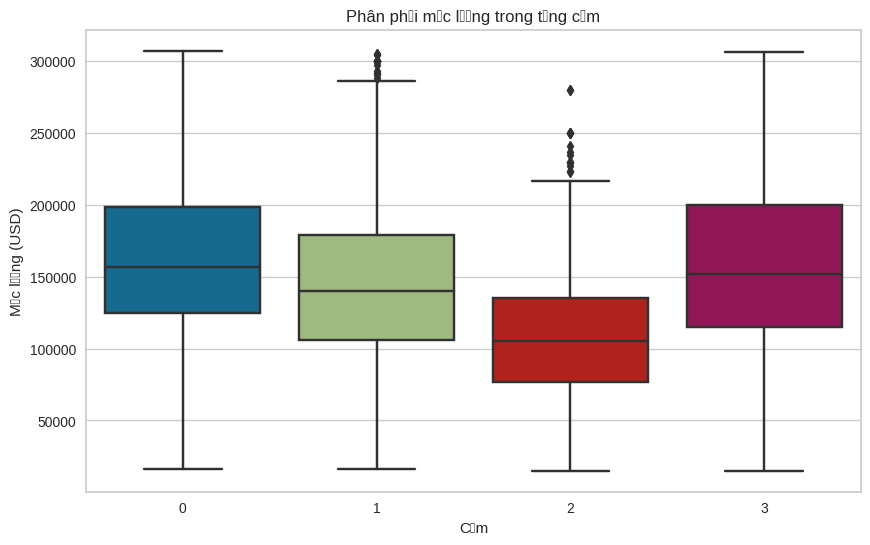

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cluster, x='cluster', y='salary_in_usd')
plt.title('Phân phối mức lương trong từng cụm')
plt.xlabel('Cụm')
plt.ylabel('Mức lương (USD)')
plt.show()

####remote_ratio

In [ ]:
remote_ratio_cross_tab = pd.crosstab(df_cluster['remote_ratio'], df_cluster['cluster'])
print("\nPhân phối của cột 'remote_ratio' trong từng cụm:")
print(remote_ratio_cross_tab)


Phân phối của cột 'remote_ratio' trong từng cụm:
cluster              0     1    2     3
remote_ratio                           
Fully remote      1563  1279  832  1490
No remote work    1032   767  656   812
Partially remote    95    31   36    53


In [ ]:
# Tính tỉ lệ theo cụm (tổng theo cụm là 1)
remote_ratio_percentage = remote_ratio_cross_tab.apply(lambda x: x/x.sum(), axis=1)

# In phân phối tỉ lệ của từng thành phần theo cụm
print("\nPhân phối của cột 'remote_ratio' trong từng cụm theo phần trăm:")
print(remote_ratio_percentage)



Phân phối của cột 'remote_ratio' trong từng cụm theo phần trăm:
cluster                  0         1         2         3
remote_ratio                                            
Fully remote      0.302672  0.247676  0.161115  0.288536
No remote work    0.315886  0.234772  0.200796  0.248546
Partially remote  0.441860  0.144186  0.167442  0.246512


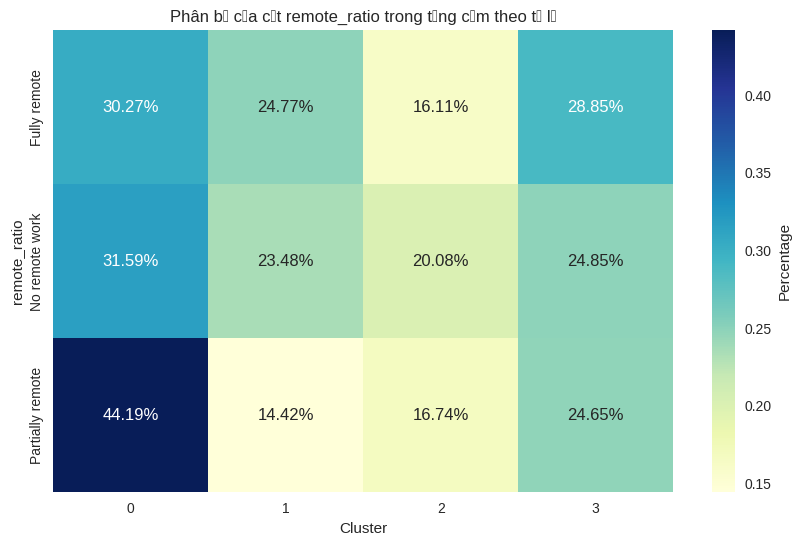

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(remote_ratio_percentage, annot=True, fmt=".2%", cmap="YlGnBu", cbar_kws={'label': 'Percentage'})
plt.title("Phân bố của cột remote_ratio trong từng cụm theo tỷ lệ")
plt.ylabel("remote_ratio")
plt.xlabel("Cluster")
plt.show()

####job_title_clean

In [ ]:
job_title_clean_cross_tab = pd.crosstab(df_cluster['job_title_clean'], df_cluster['cluster'])
print("\nPhân phối của cột 'job_title_clean':")
print(job_title_clean_cross_tab)


Phân phối của cột 'job_title_clean':
cluster                       0     1     2     3
job_title_clean                                  
Data Analyst                  0     0  1524     0
Data Engineer                 0  2077     0     0
Data Scientist             2690     0     0     0
Machine Learning Engineer     0     0     0  1132
Other                         0     0     0  1223


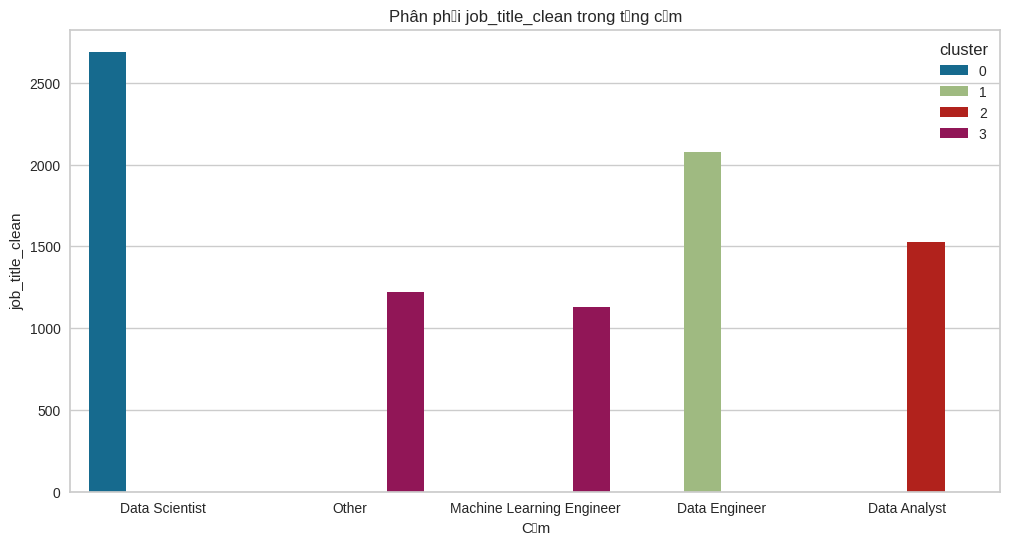

In [ ]:
fig, axes = plt.subplots( figsize=(12, 6))

sns.countplot(data=df_cluster, x='job_title_clean', hue='cluster')
plt.title('Phân phối job_title_clean trong từng cụm')
plt.xlabel('Cụm')
plt.ylabel('job_title_clean')

plt.show()

####company_size

In [ ]:
company_size_cross_tab = pd.crosstab(df_cluster['company_size'], df_cluster['cluster'])
print("\nPhân phối của cột 'company_size':")
print(company_size_cross_tab)


Phân phối của cột 'company_size':
cluster          0     1     2     3
company_size                        
Large          336   117    87   198
Medium        2292  1942  1409  2099
Small           62    18    28    58


In [ ]:
# Tính tỉ lệ theo cụm (tổng theo cụm là 1)
company_size_percentage = company_size_cross_tab.apply(lambda x: x/x.sum(), axis=1)

# In phân phối tỉ lệ của từng thành phần theo cụm
print("\nPhân phối của cột 'company_size' trong từng cụm theo phần trăm:")
print(company_size_percentage)



Phân phối của cột 'company_size' trong từng cụm theo phần trăm:
cluster              0         1         2         3
company_size                                        
Large         0.455285  0.158537  0.117886  0.268293
Medium        0.296048  0.250840  0.181994  0.271119
Small         0.373494  0.108434  0.168675  0.349398


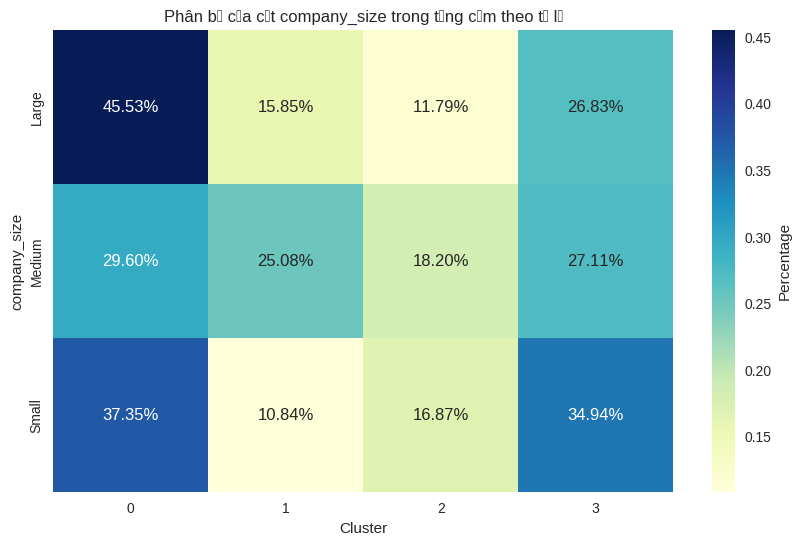

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(company_size_percentage, annot=True, fmt=".2%", cmap="YlGnBu", cbar_kws={'label': 'Percentage'})
plt.title(f"Phân bố của cột company_size trong từng cụm theo tỷ lệ")
plt.ylabel("company_size")
plt.xlabel("Cluster")
plt.show()

####experience_level

In [ ]:
experience_level_cross_tab = pd.crosstab(df_cluster['experience_level'], df_cluster['cluster'])
print("\nPhân phối của cột 'experience_level':")
print(experience_level_cross_tab)


Phân phối của cột 'experience_level':
cluster              0     1    2     3
experience_level                       
Entry              139   100  131    97
Executive           73    92   14    69
Mid                457   425  411   430
Senior            2021  1460  968  1759


In [ ]:
# Tính tỉ lệ theo cụm (tổng theo cụm là 1)
experience_level_percentage = experience_level_cross_tab.apply(lambda x: x/x.sum(), axis=1)

# In phân phối tỉ lệ của từng thành phần theo cụm
print("\nPhân phối của cột 'experience_level' trong từng cụm theo phần trăm:")
print(experience_level_percentage)


Phân phối của cột 'experience_level' trong từng cụm theo phần trăm:
cluster                  0         1         2         3
experience_level                                        
Entry             0.297645  0.214133  0.280514  0.207709
Executive         0.294355  0.370968  0.056452  0.278226
Mid               0.265235  0.246663  0.238537  0.249565
Senior            0.325548  0.235180  0.155928  0.283344


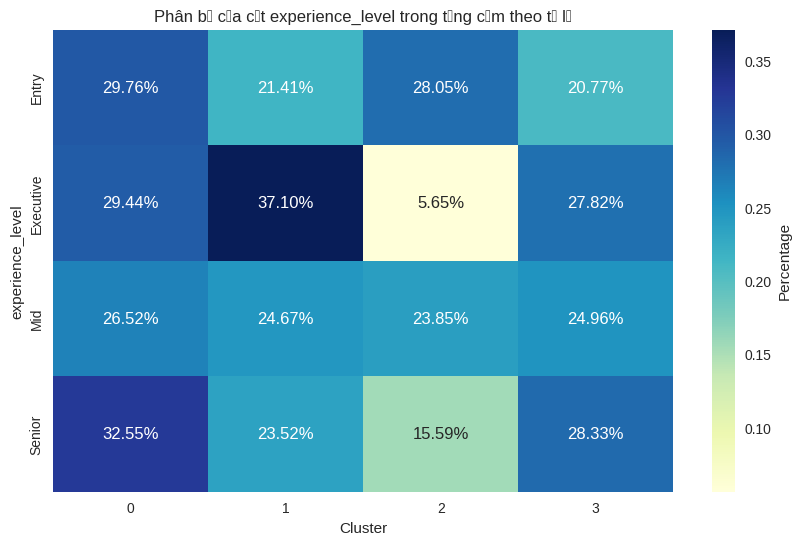

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(experience_level_percentage, annot=True, fmt=".2%", cmap="YlGnBu", cbar_kws={'label': 'Percentage'})
plt.title("Phân bố của cột experience_level trong từng cụm theo tỷ lệ")
plt.ylabel("experience_level")
plt.xlabel("Cluster")
plt.show()

## Mô hình dự đoán

### Hàm đánh giá

In [ ]:
def evaluate_regression_model(y_true, y_pred):
    results = {}

    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    results['MSE'] = mse

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    results['MAE'] = mae

    # R-squared
    r_squared = r2_score(y_true, y_pred)
    results['R-squared'] = r_squared

    # Median Absolute Error
    median_ae = median_absolute_error(y_true, y_pred)
    results['Median Absolute Error'] = median_ae

    # Explained Variance Score
    explained_variance = explained_variance_score(y_true, y_pred)
    results['Explained Variance Score'] = explained_variance

    # Max Error
    max_err = max_error(y_true, y_pred)

    return results

### Random Forest

In [ ]:
## Mô tả dữ liệu
## Biến phân lớp (target variable): 'Class' --> cột cuối cùng trong file
target = 'salary_in_usd'
print('* Biến target:', target)

## Danh sách các features
nb_features = df_rd.shape[1] - 1
features    = df_rd.drop(target, axis=1).columns
print('* Số lượng features = %2d' %nb_features)
print('  Các features:', ', '.join(features))

* Biến target: salary_in_usd
* Số lượng features =  6
  Các features: work_year, remote_ratio_clean, usa, company_size_clean, experience_level_clean, job_title_rd


In [ ]:
X = df_rd[features]
y = df_rd[target]
# Tạo tập huấn luyện và tập dữ liệu còn lại
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Chia tập dữ liệu còn lại thành tập kiểm tra và tập validation
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Tạo mô hình Random Forest
rf_model = RandomForestRegressor()

# Định nghĩa các tham số cần tìm kiếm
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Sử dụng GridSearchCV để tìm kiếm các tham số tốt nhất
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# In ra các tham số tốt nhất
print("Best parameters: ", grid_search.best_params_)

# Dự đoán trên tập val
y_pred = grid_search.predict(X_val)

# Đưa ra các chỉ số đánh giá của mô hình
evaluate_regression_model(y_val, y_pred)

Best parameters:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}


{'MSE': 0.026742496450317767,
 'MAE': 0.12788695799479288,
 'R-squared': 0.3383301815091375,
 'Median Absolute Error': 0.10615658245708715,
 'Explained Variance Score': 0.3384064151350954}

### Linear Regression

In [ ]:
## Mô tả dữ liệu
## Biến phân lớp (target variable): 'Class' --> cột cuối cùng trong file
target = 'salary_in_usd'
print('* Biến target:', target)

## Danh sách các features
nb_features = df_lr_svm_pca.shape[1] - 1
features    = df_lr_svm_pca.drop(target, axis=1).columns
print('* Số lượng features = %2d' %nb_features)
print('  Các features:\n', ',\n'.join(features))

* Biến target: salary_in_usd
* Số lượng features =  6
  Các features:
 Principal Component 1,
Principal Component 2,
Principal Component 3,
Principal Component 4,
Principal Component 5,
Principal Component 6


In [ ]:
X = df_lr_svm_pca[features]
y = df_lr_svm_pca[target]
# Tạo tập huấn luyện và tập dữ liệu còn lại
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Chia tập dữ liệu còn lại thành tập kiểm tra và tập validation
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Tạo mô hình Linear Regression
lr_model = LinearRegression()

# Huấn luyện mô hình
lr_model.fit(X_train, y_train)

# Dự đoán trên tập val
y_pred = lr_model.predict(X_val)

# Các chỉ số đánh giá mô hình
evaluate_regression_model(y_val, y_pred)

{'MSE': 0.026829413269906118,
 'MAE': 0.12951995545164466,
 'R-squared': 0.3361796629011359,
 'Median Absolute Error': 0.1076230993269851,
 'Explained Variance Score': 0.3365634052333927}

### SVM

In [ ]:
# SVM và Linear Regression sử dụng chung tập tiền xử lý.
# Định nghĩa mô hình SVM
svm_model = SVR()

# Định nghĩa các tham số cần tìm kiếm
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1],
    'epsilon': [0.1, 0.2, 0.5]
}

# Sử dụng GridSearchCV để tìm kiếm các tham số tốt nhất
grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_svm.fit(X_train, y_train)

# In ra các tham số tốt nhất
print("Best parameters: ", grid_search_svm.best_params_)

# Dự đoán trên tập val
y_pred = grid_search_svm.predict(X_val)

# Đánh giá mô hình bằng các chỉ số
evaluate_regression_model(y_val, y_pred)

Best parameters:  {'C': 10, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}


{'MSE': 0.026576916307882385,
 'MAE': 0.1274178271118674,
 'R-squared': 0.34242700855721997,
 'Median Absolute Error': 0.10461847022200094,
 'Explained Variance Score': 0.3465907058465425}

### Chọn lựa giải pháp

#### Cross Validation

In [ ]:
## Các mô hình ứng viên
models = [LinearRegression(),
          SVR(C = 10, epsilon = 0.1, gamma = 'auto', kernel = 'rbf')]

In [ ]:
## Mô tả dữ liệu
## Biến phân lớp (target variable): 'Class' --> cột cuối cùng trong file
target = 'salary_in_usd'
nb_features = df_lr_svm_pca.shape[1] - 1
features    = df_lr_svm_pca.drop(target, axis=1).columns
X = df_lr_svm_pca[features]
y = df_lr_svm_pca[target]

In [ ]:
folds = 10
for model in models:
    model_name = model.__class__.__name__
    mse_scorer = make_scorer(mean_squared_error)
    mse = cross_val_score(model, X, y, scoring = mse_scorer, cv = folds)
    print(f'Mean Squared Error (trung bình) của mô hình {model_name} = {mse.mean():.4f}')

Mean Squared Error (trung bình) của mô hình LinearRegression = 0.0273
Mean Squared Error (trung bình) của mô hình SVR = 0.0273


In [ ]:
## Cross validation cho mô hình Random Forest
target = 'salary_in_usd'
nb_features = df_rd.shape[1] - 1
features    = df_rd.drop(target, axis=1).columns
X = df_rd[features]
y = df_rd[target]

model_rd = RandomForestRegressor(max_depth= 20, min_samples_leaf = 2, min_samples_split = 10, n_estimators = 200)
mse = cross_val_score(model_rd, X, y, scoring = mse_scorer, cv = folds)
print(f'Mean Squared Error (trung bình) của mô hình Random Forest = {mse.mean():.4f}')

Mean Squared Error (trung bình) của mô hình Random Forest = 0.0272


### Đánh giá mô hình lựa chọn

In [ ]:
y_pred = grid_search_svm.predict(X_test)
# Đánh giá mô hình bằng các chỉ số
evaluate_regression_model(y_test, y_pred)

{'MSE': 0.024780993523897003,
 'MAE': 0.12430273672372051,
 'R-squared': 0.31843558526319315,
 'Median Absolute Error': 0.10382795420597607,
 'Explained Variance Score': 0.31843776371527277}

Bias: 0.04166085078296449
Variance: 0.01464229964672343
MSE: 0.0273358426900374


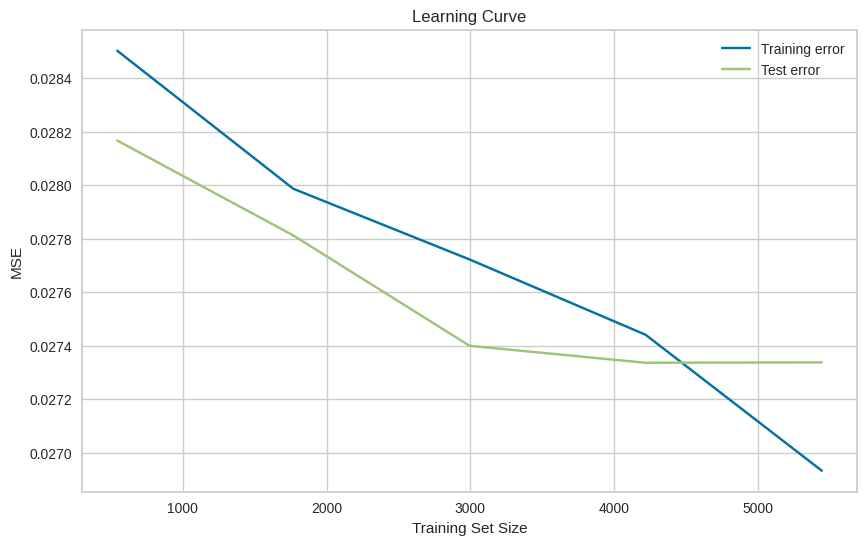

In [ ]:
# Tạo mô hình SVM
svm_model = SVR(C = 10, epsilon = 0.1, gamma = 'auto', kernel = 'rbf')

# Hàm tính bias, variance, và MSE
def bias_variance_analysis(model, X, y):
    # Tính toán các giá trị dự đoán trên tập huấn luyện
    y_pred = cross_val_predict(model, X, y, cv=10)

    # Tính MSE
    mse = mean_squared_error(y, y_pred)

    # Tính bias
    bias = np.mean((y - np.mean(y_pred))**2)

    # Tính variance
    variance = np.var(y_pred)

    return bias, variance, mse

# Đánh giá bias, variance, và MSE
bias, variance, mse = bias_variance_analysis(svm_model, X_train, y_train)

print(f'Bias: {bias}')
print(f'Variance: {variance}')
print(f'MSE: {mse}')

# Vẽ đồ thị learning curve để quan sát trade-off giữa bias và variance
train_sizes, train_scores, test_scores = learning_curve(svm_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, test_scores_mean, label='Cross - validation error')
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.title('Learning Curve')
plt.legend()
plt.show()